In [1]:
import hdbscan
import itertools 
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
%matplotlib inline
from bokeh.plotting import figure, output_file, show
from operator import itemgetter
from pandas.tools.plotting import scatter_matrix
from scipy.spatial.distance import euclidean
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN, KMeans, MeanShift
from sklearn.metrics import accuracy_score, r2_score, roc_curve, auc, confusion_matrix, f1_score,  silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# That EDA.

In [3]:
frame = pd.read_csv('final_data_case.csv')

In [4]:
frame.columns = ['age', 'gender', 'flu_season', 'ed_admit', 'severity', 'comorbidity', 'readmit30']

In [5]:
frame.head()

age  gender  flu_season  ed_admit  severity  comorbidity  readmit30
0  100       1           1         1        38          112          0
1   83       1           0         1         8          109          1
2   74       0           1         0         1           80          0
3   66       1           1         1        25            4          0
4   68       1           1         1        25           32          0

#### Delete duplicates.

In [6]:
frame.drop_duplicates(keep='first', inplace=True)

#### Basic data info.

In [7]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4381
Data columns (total 7 columns):
age            4372 non-null int64
gender         4372 non-null int64
flu_season     4372 non-null int64
ed_admit       4372 non-null int64
severity       4372 non-null int64
comorbidity    4372 non-null int64
readmit30      4372 non-null int64
dtypes: int64(7)
memory usage: 273.2 KB


#### Data statistics.

In [8]:
frame.describe()

age       gender   flu_season     ed_admit     severity  \
count  4372.000000  4372.000000  4372.000000  4372.000000  4372.000000   
mean     76.857045     0.469808     0.407594     0.810156    22.385636   
std       7.905581     0.499145     0.491443     0.392223    18.006505   
min      65.000000     0.000000     0.000000     0.000000     1.000000   
25%      70.000000     0.000000     0.000000     1.000000     8.000000   
50%      76.000000     0.000000     0.000000     1.000000    19.000000   
75%      82.000000     1.000000     1.000000     1.000000    32.000000   
max     105.000000     1.000000     1.000000     1.000000   112.000000   

       comorbidity    readmit30  
count  4372.000000  4372.000000  
mean     94.770357     0.228042  
std      57.161220     0.419618  
min       1.000000     0.000000  
25%      51.000000     0.000000  
50%      86.000000     0.000000  
75%     131.000000     0.000000  
max     322.000000     1.000000

#### Feature Correlation matrix.

In [9]:
cmap = sns.diverging_palette(5, 250, as_cmap=True)
frame.corr().style.background_gradient(cmap, axis=1)

#### Feature Density

/home/ubuntu/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


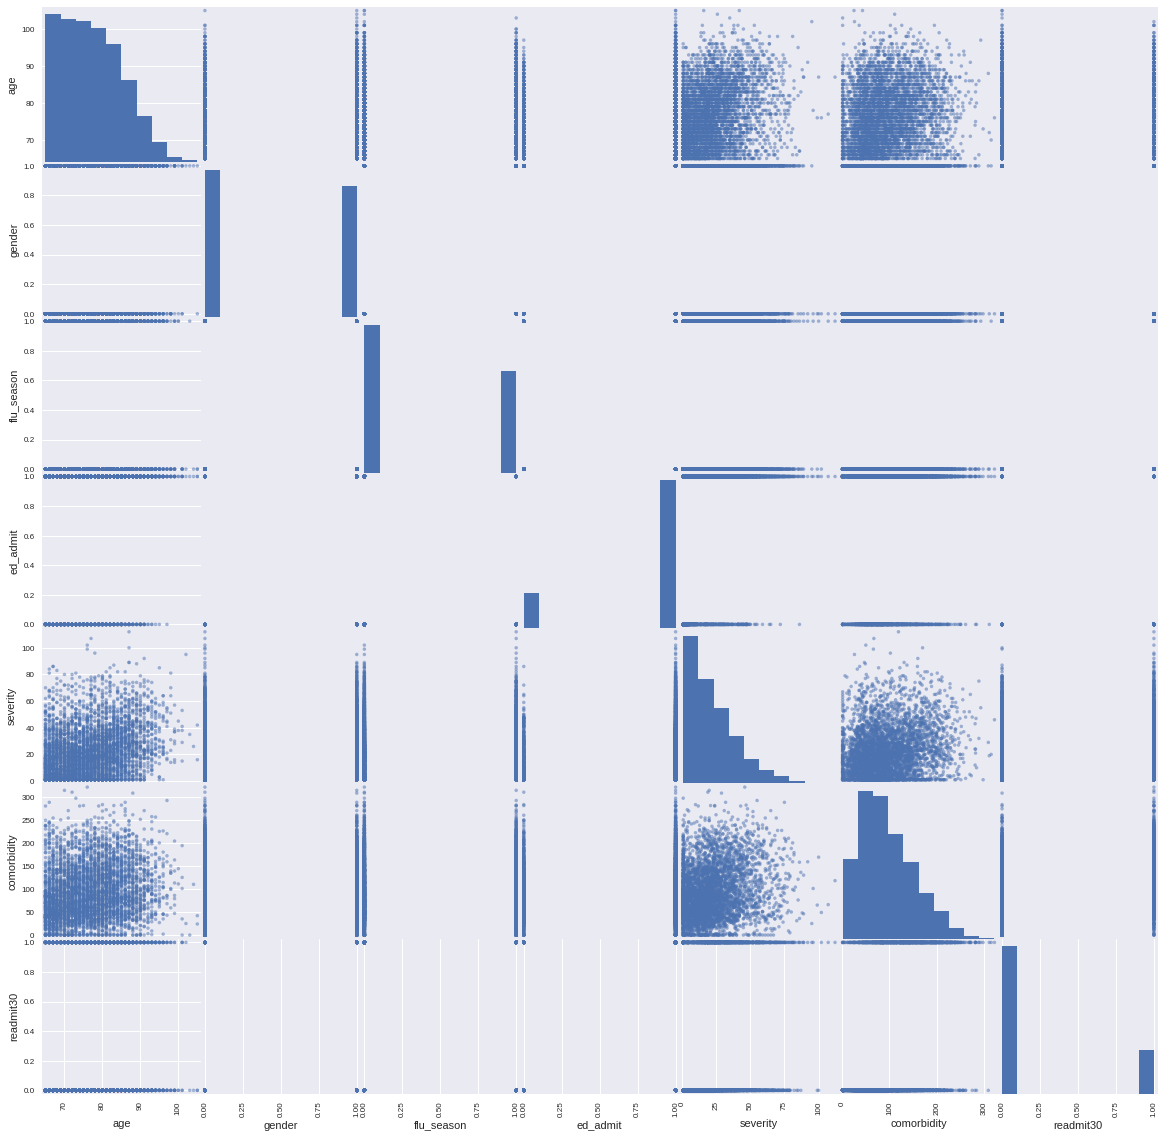

In [10]:
scatter_matrix(frame, figsize=(20,20), diagonal = 'hist');

####  Class Imbalance.

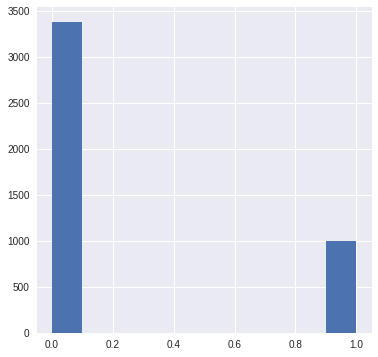

In [11]:
frame['readmit30'].hist(figsize = (6, 6))

# Predict Readmission in 30 days.

#### Split to train and test.

In [12]:
X = np.array(frame[['age']+['gender']+['flu_season']+['ed_admit']+['severity']+['comorbidity']].values.tolist())
Y = frame['readmit30'].values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X,Y)

#### Plot Train and test class imbalance.

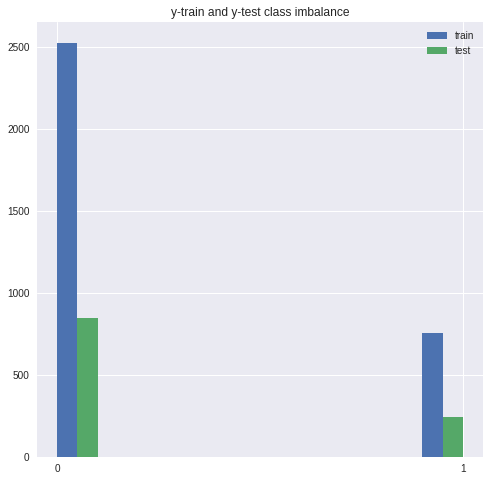

In [13]:
plt.figure(figsize=(8,8))
plt.hist([y_train, y_test], range=[0, 1], label = ['train', 'test'], rwidth = 10);
plt.xticks([0, 1])
plt.legend()
plt.title('y-train and y-test class imbalance')

## Logistic Regression.

#### Define Logistic Regression.

In [14]:
log = LogisticRegression()

#### Fitting Logistic Regression on class imbalanced data.

In [15]:
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Predicting.

In [16]:
preds = log.predict(X_test)
predsprob = log.predict_proba(X_test)

#### Getting the Metrics.

In [17]:
# Model, Accuracy, R2, RMSE, F1
metrics=[
            ['Log Regression-Class imbalanced',
            float(str(round(abs(accuracy_score(y_test, preds)),4))),
            float(str(round(abs(r2_score(y_test, preds)),4))),
            float(str(round(abs(euclidean(y_test, preds)/math.sqrt(len(y_test))),4))),
            float(str(round(abs(f1_score(y_test, preds)),4)))
            ]
        ]
metrics

[['Log Regression-Class imbalanced', 0.8106, 0.0922, 0.4352, 0.4136]]

#### Attempt of circumventing class imbalance with an undersampling of classes.

In [18]:
readmits = frame[frame['readmit30'] == 1]
readmits_X = readmits[['age']+['gender']+['flu_season']+['ed_admit']+['severity']+['comorbidity']].values.tolist()
readmits_Y = np.array(readmits['readmit30'].values.tolist())
len(readmits_X)

non_readmits = frame[frame['readmit30'] == 0]
non_readmits_X = non_readmits[['age']+['gender']+['flu_season']+['ed_admit']+['severity']+['comorbidity']].values.tolist()[0:1000]
non_readmits_Y = non_readmits['readmit30'].values.tolist()[0:1000]

non_readmits_X1 = non_readmits[['age']+['gender']+['flu_season']+['ed_admit']+['severity']+['comorbidity']].values.tolist()[1000:]
non_readmits_Y1 = non_readmits['readmit30'].values.tolist()[1000:]

new_X = itertools.chain(readmits_X,non_readmits_X)
new_Y = itertools.chain(readmits_Y,non_readmits_Y)

new_X = [i for i in new_X] 
new_Y = [i for i in new_Y]

In [19]:
print (len(new_X), len(new_Y))
print (len(non_readmits_X1), len(non_readmits_Y1))

1997 1997
2375 2375


#### Fitting Logistic Regression for new class balanced data by undersampling.

#### Cross train validation.

In [20]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X,new_Y)

In [21]:
print (len(new_X_train), len(new_y_train))
print (len(new_X_test), len(new_y_test))

1497 1497
500 500


#### Add the exluded undersampled class data to test.

In [22]:
new_X_test.extend(non_readmits_X1)
new_y_test.extend(non_readmits_Y1)

In [23]:
print (len(new_X_test), len(new_y_test))
print (len(new_X_train[0]), len(new_X_test[-1])) # Features in a X value

2875 2875
6 6


#### Fit.

In [24]:
log.fit(new_X_train, new_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Predict.

In [25]:
preds = log.predict(new_X_test)
predsprob = log.predict_proba(new_X_test)

#### Gather Metrics.

In [26]:
# Model, Accuracy, R2, RMSE, F1
metrics.append(['Log Regression-Class balance(undersample)',
                float(str(round(abs(accuracy_score(new_y_test, preds)),4))),
                float(str(round(abs(r2_score(new_y_test, preds)),4))),
                float(str(round(abs(euclidean(new_y_test, preds)/math.sqrt(len(new_y_test))),4))),
                float(str(round(abs(f1_score(new_y_test, preds)),4)))])
metrics

[['Log Regression-Class imbalanced', 0.8106, 0.0922, 0.4352, 0.4136],
 ['Log Regression-Class balance(undersample)', 0.7273, 2.3737, 0.5222, 0.3099]]

## Random Forest.

#### Defining Random Forest for class imbalanced data.

#### Grid Search hyperparameters.

In [27]:
rfparam = {'n_estimators':[i for i in range(100,500,50)],'max_depth':[i for i in range(1,5)]}

In [28]:
rfgrid = GridSearchCV( RandomForestClassifier(),rfparam)

In [29]:
rfgrid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450], 'max_depth': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [30]:
rf = rfgrid.best_estimator_

#### Fit.

In [31]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Predict.

In [32]:
preds = rf.predict(X_test)
predsprob = rf.predict_proba(X_test)

#### Gather Metrics.

In [33]:
# Model, Accuracy, R2, RMSE, F1
metrics.append(['Random Forest-Class imbalanced',
                float(str(round(abs(accuracy_score(y_test, preds)),4))),
                float(str(round(abs(r2_score(y_test, preds)),4))),
                float(str(round(abs(euclidean(y_test, preds)/math.sqrt(len(y_test))),4))),
                float(str(round(abs(f1_score(y_test, preds)),4)))])
metrics

[['Log Regression-Class imbalanced', 0.8106, 0.0922, 0.4352, 0.4136],
 ['Log Regression-Class balance(undersample)', 0.7273, 2.3737, 0.5222, 0.3099],
 ['Random Forest-Class imbalanced', 0.796, 0.1766, 0.4517, 0.2875]]

#### RF Feature Importance.

In [34]:
rffeatureimp = [i for i in zip(frame.columns,rf.feature_importances_)]                            
rffeatureimp.sort(key=itemgetter(1), reverse=True)
rffeatureimp

[('comorbidity', 0.64530601057882075),
 ('severity', 0.22551647389252485),
 ('flu_season', 0.064916656106748433),
 ('age', 0.050930320752294207),
 ('gender', 0.0077902271124556778),
 ('ed_admit', 0.0055403115571559733)]

#### Define Random Forest for class balanced data by undersampling.

#### Fit.

In [35]:
rf.fit(new_X_train, new_y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Predict.

In [36]:
preds = rf.predict(new_X_test)
predsprob = rf.predict_proba(new_X_test)

#### Gather Metrics.

In [37]:
# Model, Accuracy, R2, RMSE, F1
metrics.append(['Random Forest-Class balance(undersample)',
                float(str(round(abs(accuracy_score(new_y_test, preds)),4))),
                float(str(round(abs(r2_score(new_y_test, preds)),4))),
                float(str(round(abs(euclidean(new_y_test, preds)/math.sqrt(len(new_y_test))),4))),
                float(str(round(abs(f1_score(new_y_test, preds)),4)))])
metrics

[['Log Regression-Class imbalanced', 0.8106, 0.0922, 0.4352, 0.4136],
 ['Log Regression-Class balance(undersample)', 0.7273, 2.3737, 0.5222, 0.3099],
 ['Random Forest-Class imbalanced', 0.796, 0.1766, 0.4517, 0.2875],
 ['Random Forest-Class balance(undersample)', 0.7165, 2.5071, 0.5324, 0.2956]]

#### RF Feature Importance.

In [38]:
rffeatureimp = [i for i in zip(frame.columns,rf.feature_importances_)]                            
rffeatureimp.sort(key=itemgetter(1), reverse=True)
rffeatureimp

[('comorbidity', 0.58987879353114425),
 ('severity', 0.24990264603672102),
 ('age', 0.086049666850645551),
 ('flu_season', 0.045910373664203807),
 ('ed_admit', 0.014976467065306578),
 ('gender', 0.013282052851978665)]

## Clustering.

#### Find the best number of clusters.

In [39]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)

#### Fit.

In [40]:
clusterer.fit(X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
    prediction_data=False)

#### Find Cluster labels.

In [41]:
cluster_labels = clusterer.labels_
set(cluster_labels)

{-1, 0, 1}

In [42]:
point_probabilities = clusterer.probabilities_
len(point_probabilities)

4372

In [43]:
#### Assign cluster number

In [44]:
frame['cluster_feature'] = cluster_labels

In [45]:
frame.head()

age  gender  flu_season  ed_admit  severity  comorbidity  readmit30  \
0  100       1           1         1        38          112          0   
1   83       1           0         1         8          109          1   
2   74       0           1         0         1           80          0   
3   66       1           1         1        25            4          0   
4   68       1           1         1        25           32          0   

   cluster_feature  
0               -1  
1                1  
2                1  
3                1  
4                1

# Interesting example of clustering process.

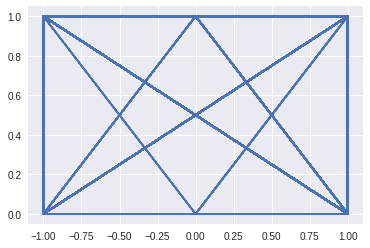

In [46]:
%matplotlib inline
plt.plot(cluster_labels,frame.readmit30)

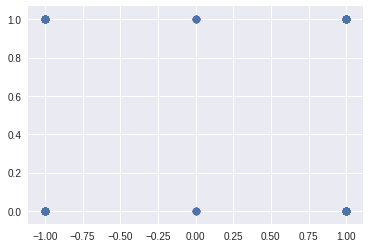

In [47]:
plt.scatter(frame.cluster_feature,frame.readmit30)

#### Find best features for clustering

In [48]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    label_names = ['age','gender','flu_season','ed_admit','severity','comorbidity']
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    for i in [0,1,2,3,4,5]:
        for j in [0,1,2,3,4,5]:
            plt.scatter(data.T[i], data.T[j], c=colors)
            #print ()
            frame = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)            
            plt.title('X-Axis:'+label_names[i]+' '+'Y-Axis:'+label_names[j]+'-Clustering took {:.2f} s'.format(end_time - start_time)+"      "+'Clusters found by {}'.format(str(algorithm.__name__),str(label_names[i])), fontsize=12, verticalalignment='bottom', horizontalalignment='center')
            #plt.title('Clusters found by {}'.format(str(algorithm.__name__),str(label_names[i])), fontsize=20)
            #plt.text(-0.5, 0.7, ('X-Axis',label_names[i],' ','Y-Axis',label_names[j],'Clustering took {:.2f} s'.format(end_time - start_time)), fontsize=21)
            plt.show()

#### Plotting pair wise clustering for features with different algorithms

###### k-Means.

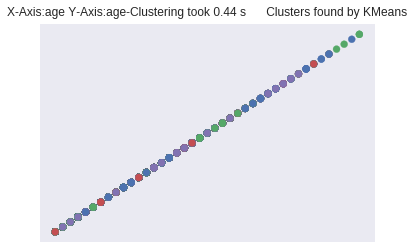

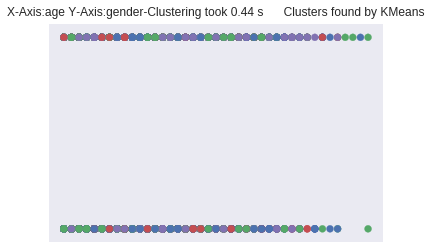

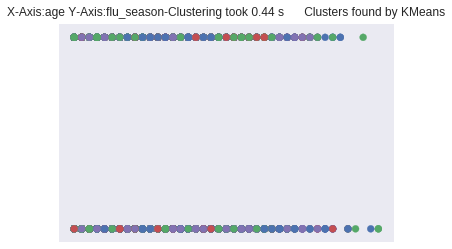

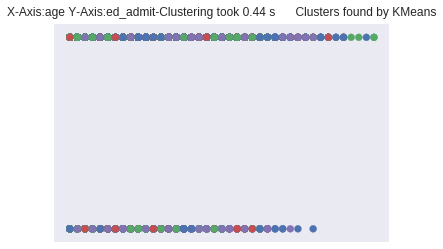

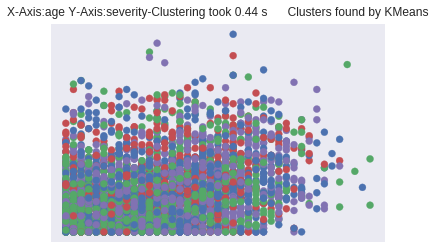

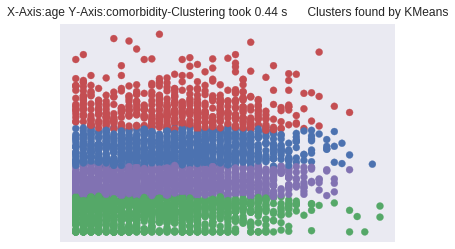

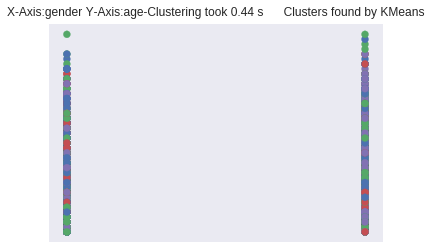

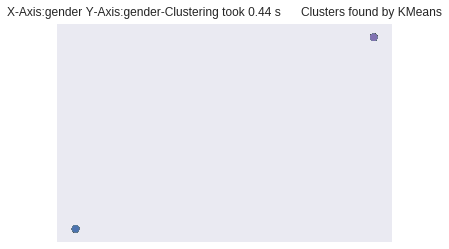

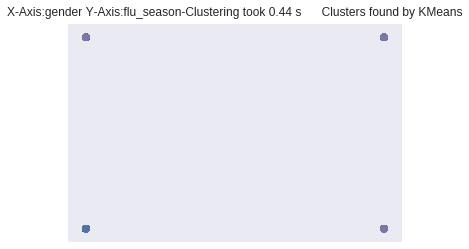

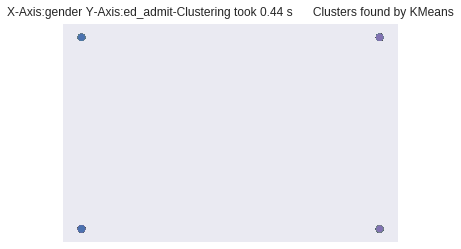

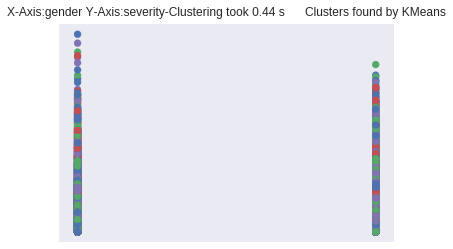

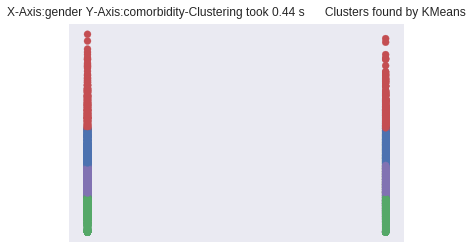

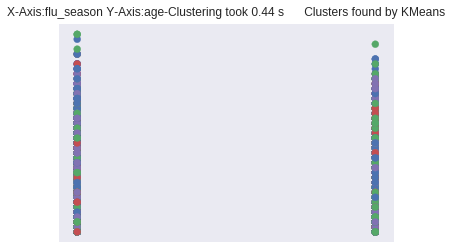

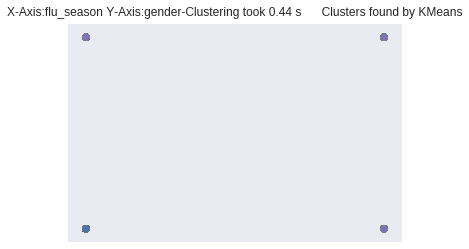

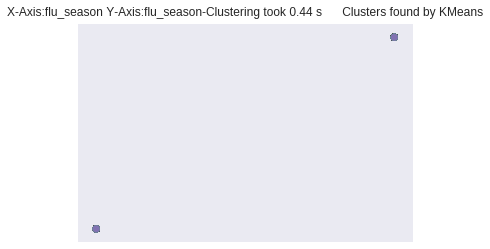

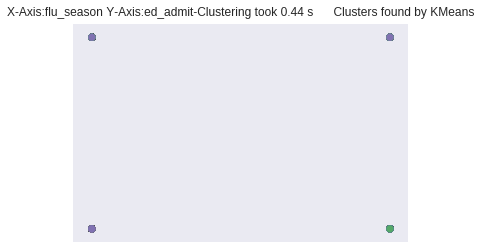

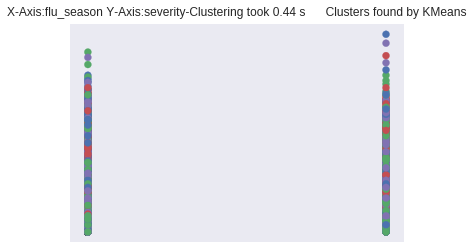

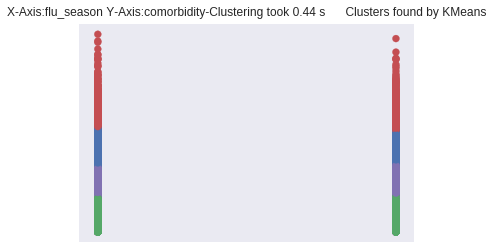

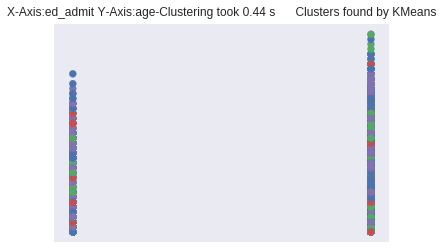

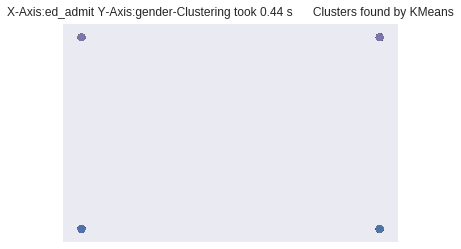

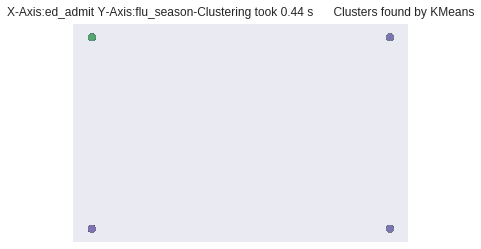

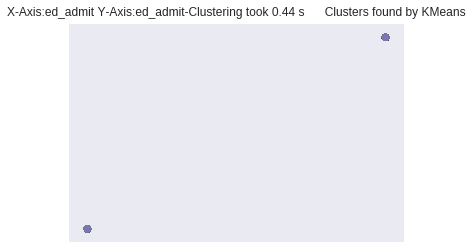

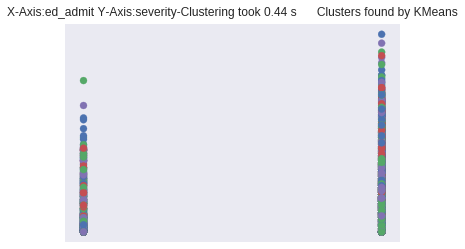

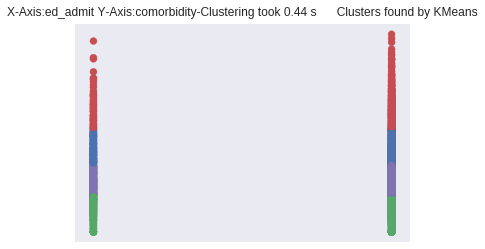

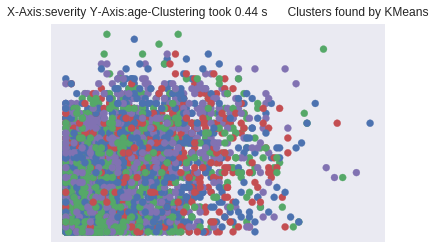

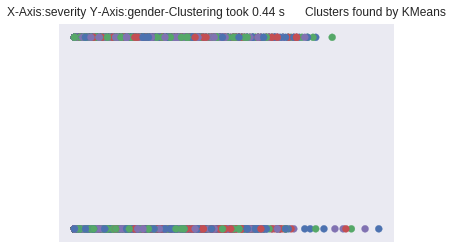

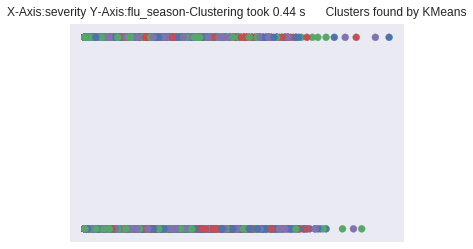

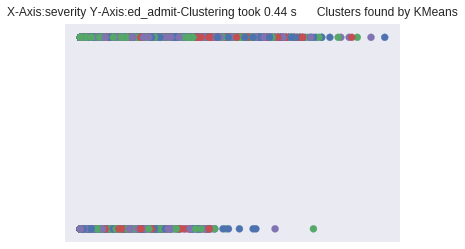

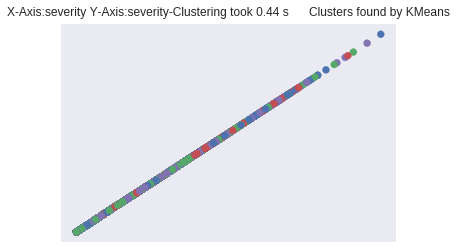

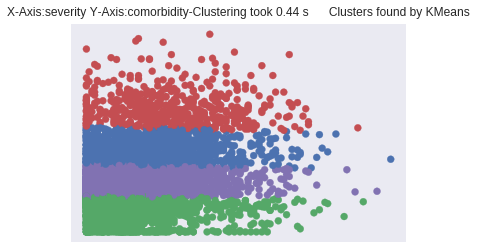

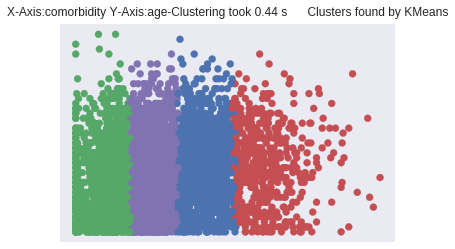

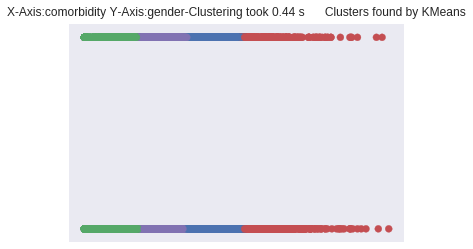

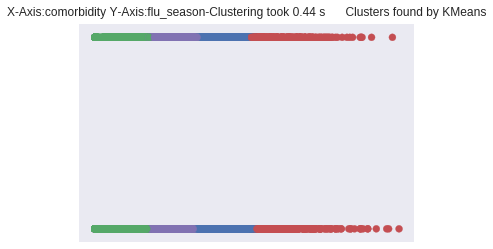

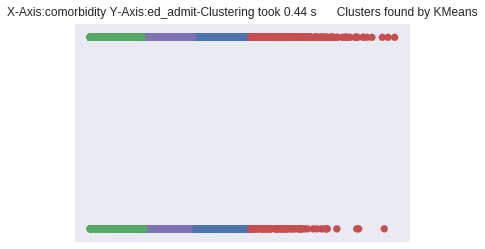

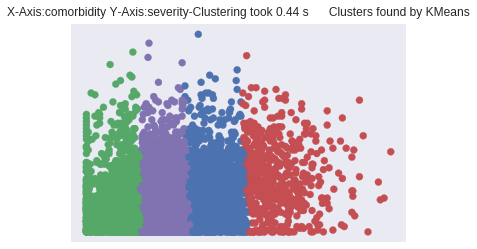

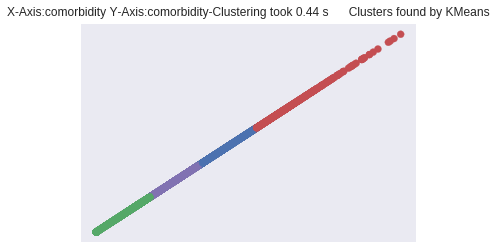

In [49]:
plot_clusters(X, KMeans, (), {'n_clusters':4})

###### AffinityPropagation.

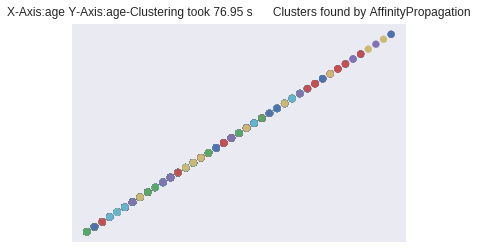

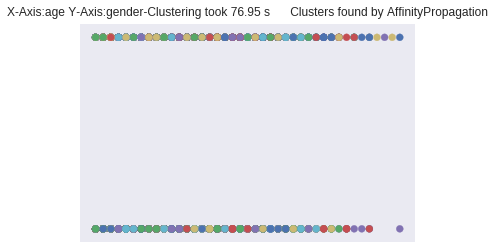

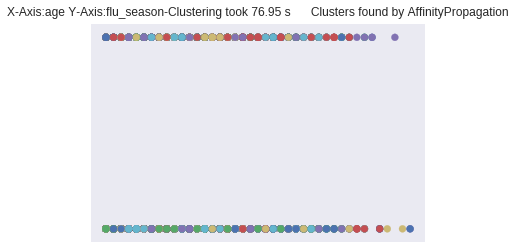

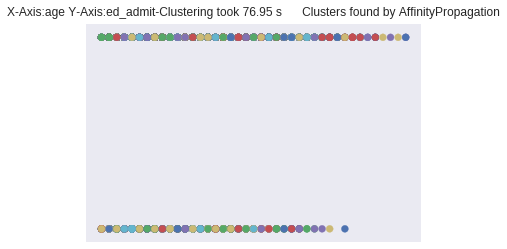

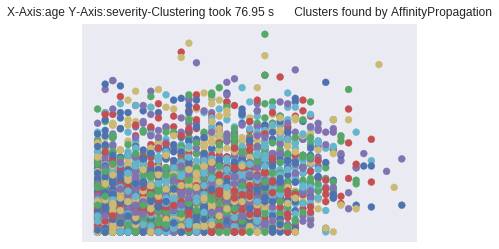

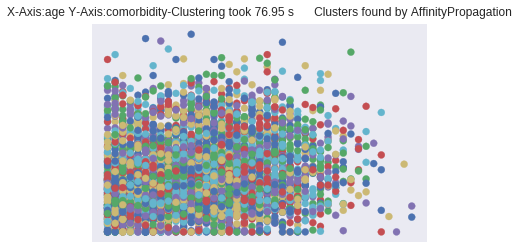

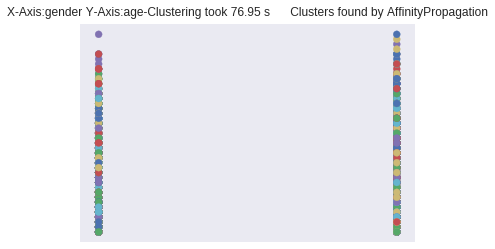

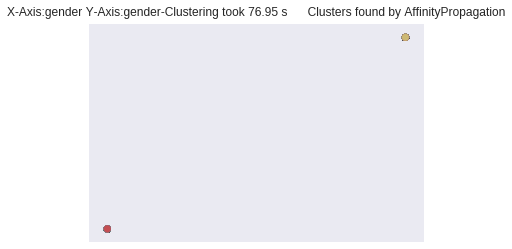

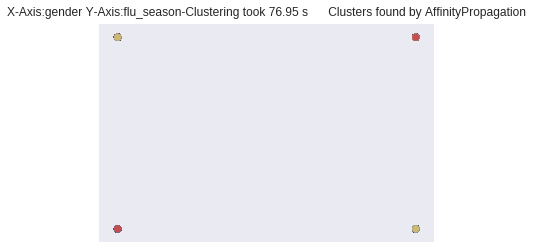

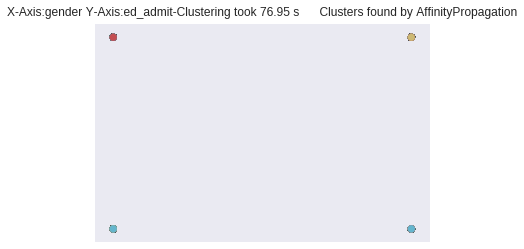

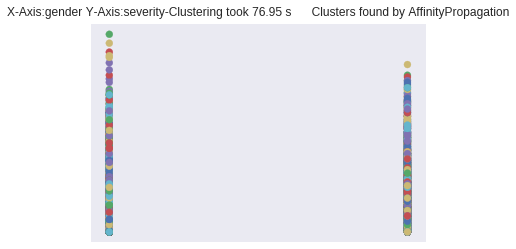

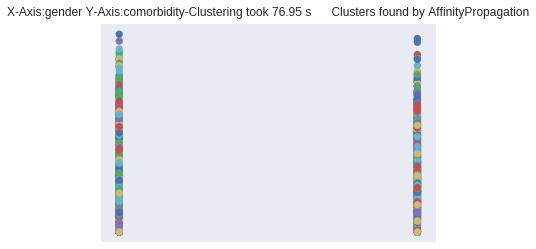

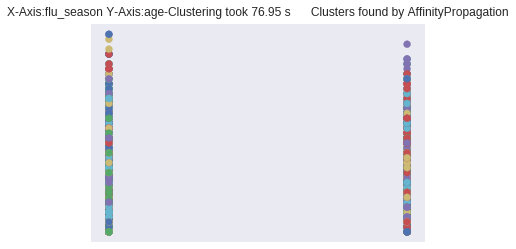

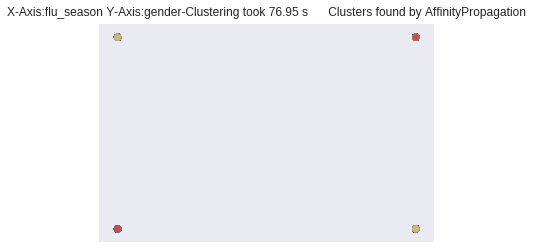

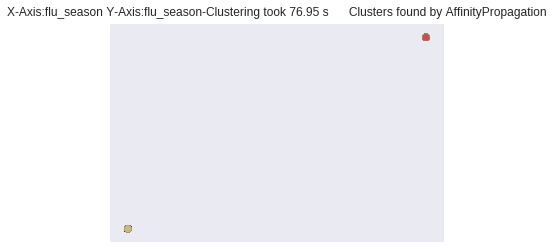

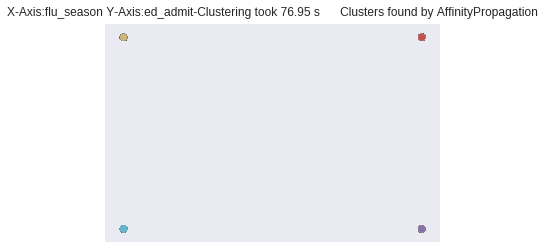

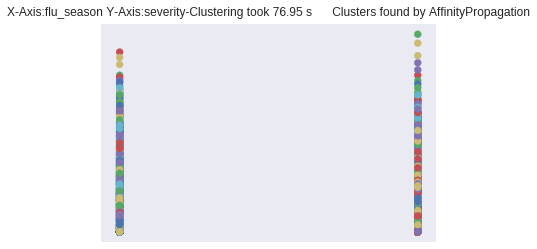

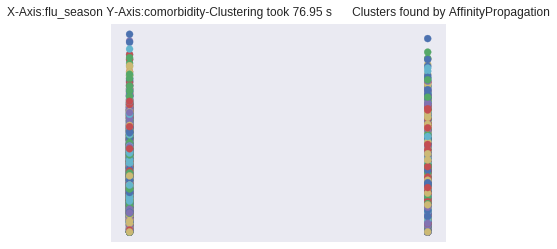

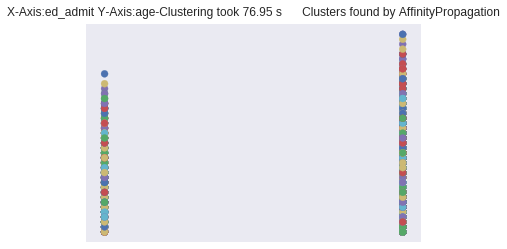

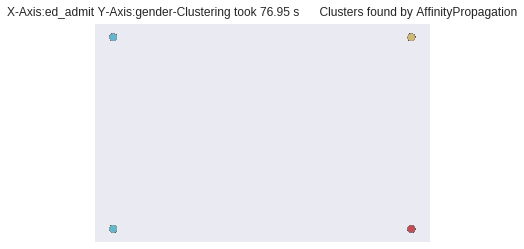

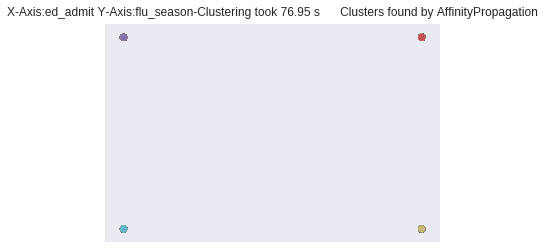

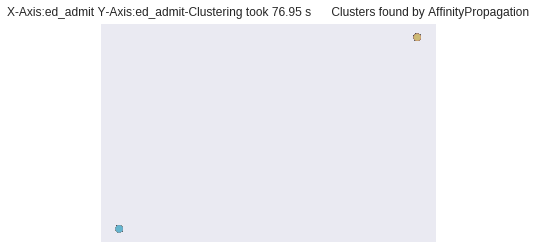

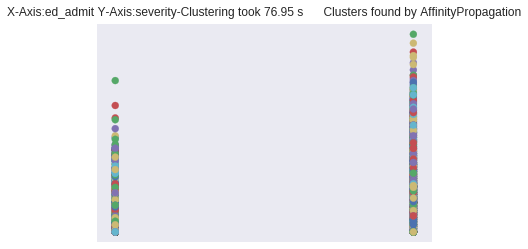

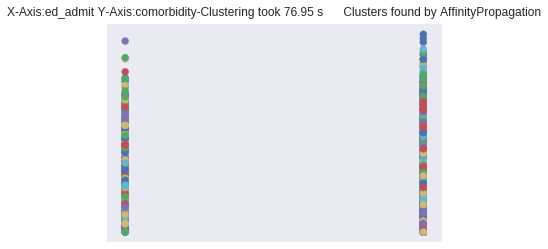

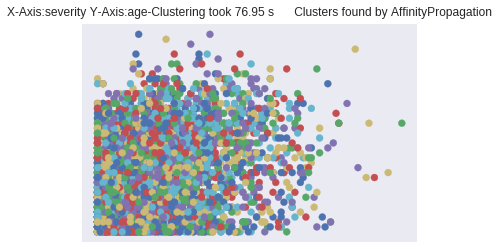

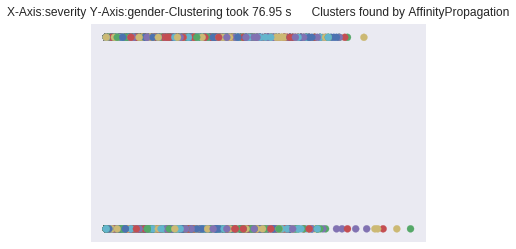

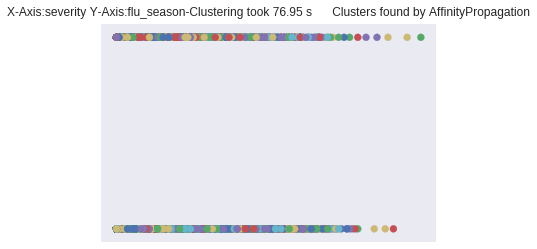

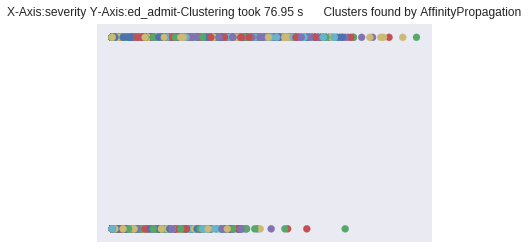

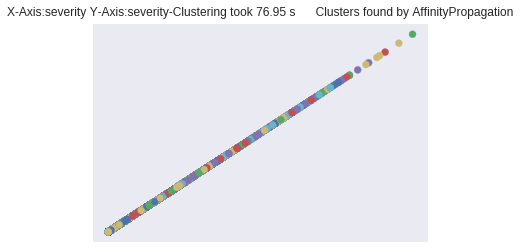

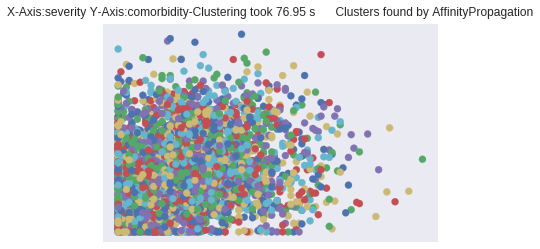

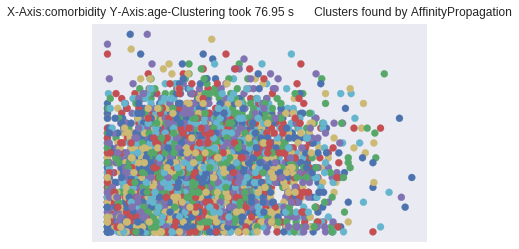

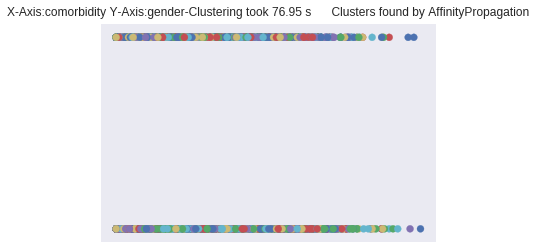

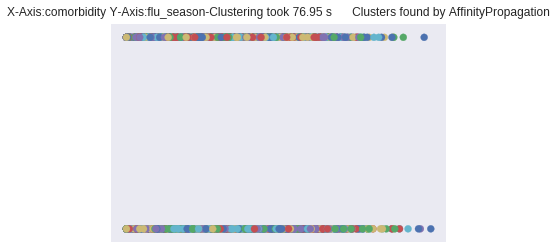

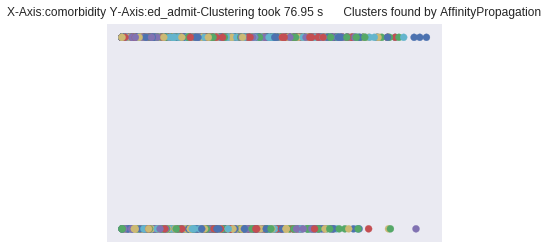

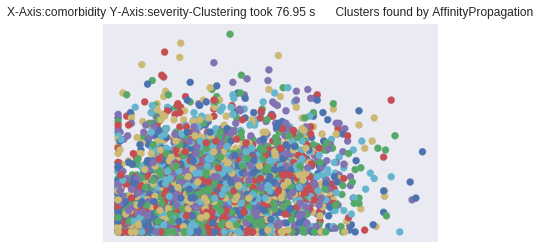

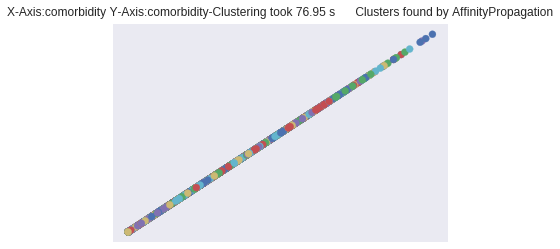

In [50]:
plot_clusters(X, AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

###### MeanShift.

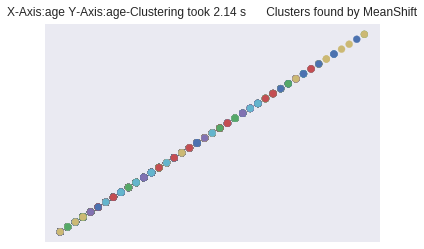

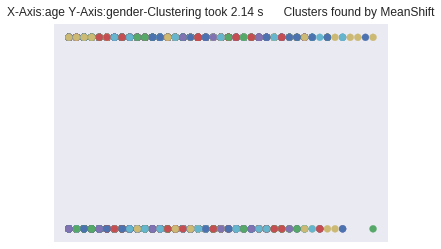

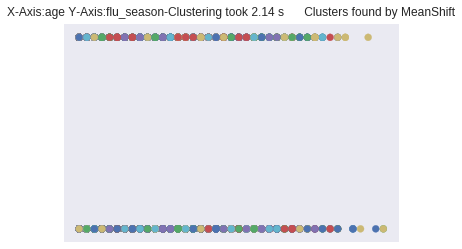

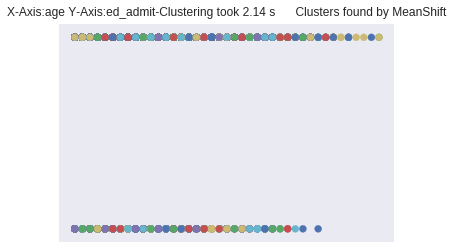

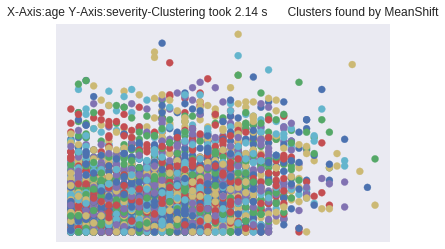

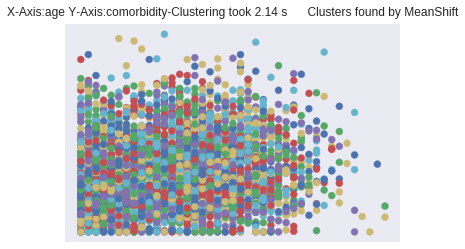

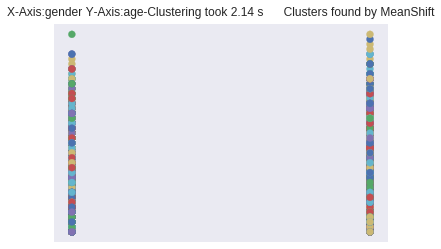

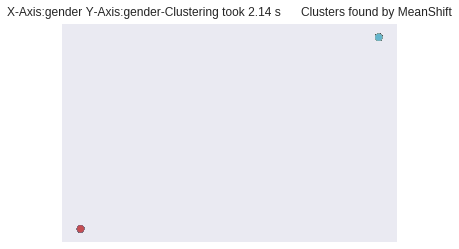

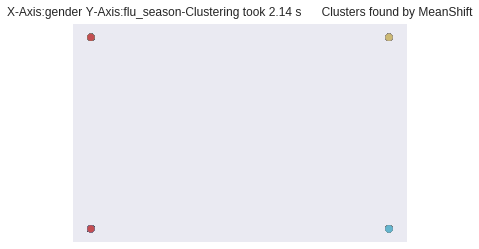

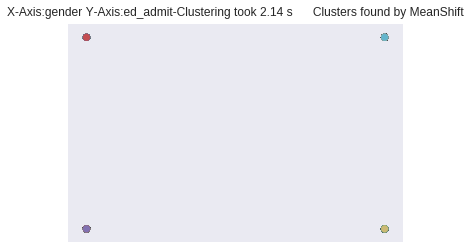

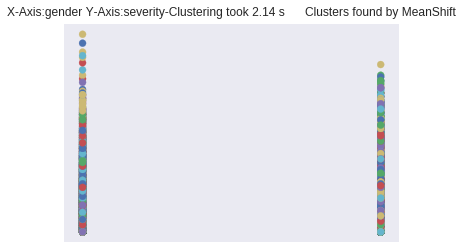

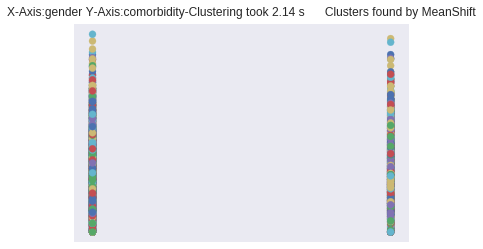

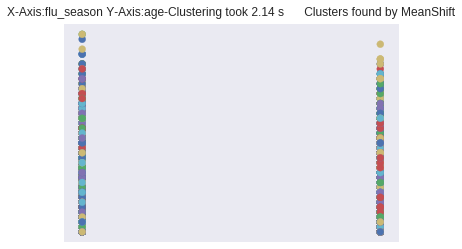

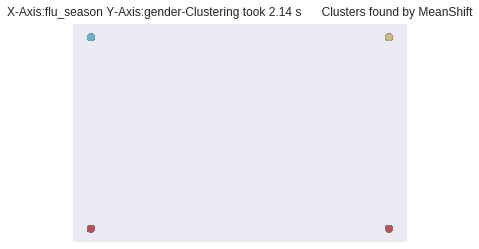

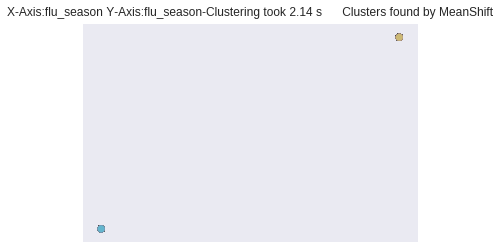

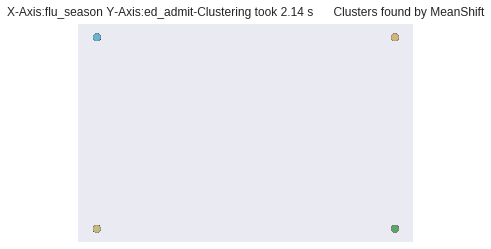

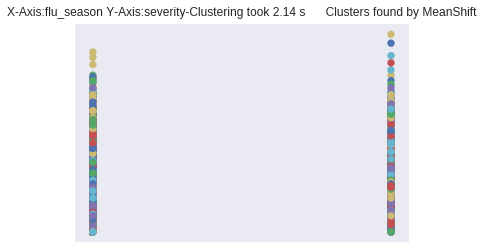

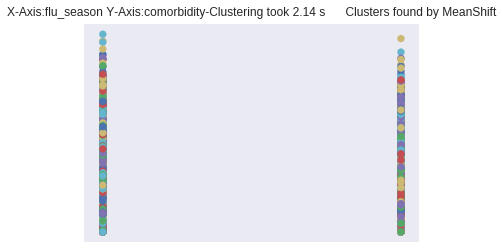

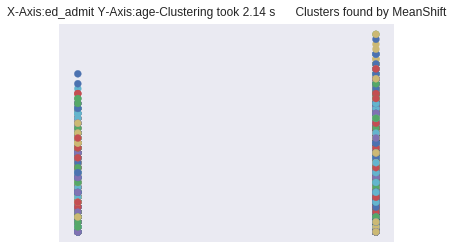

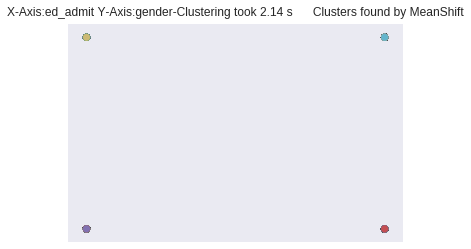

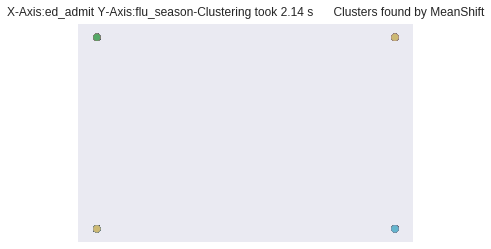

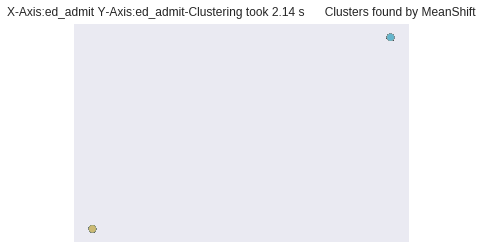

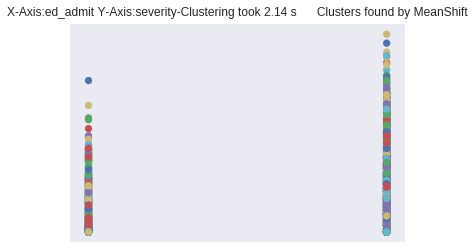

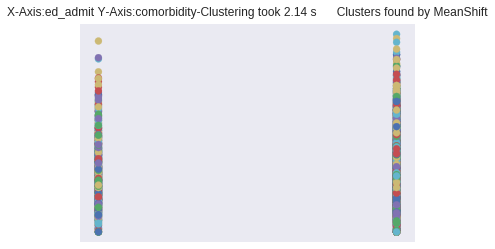

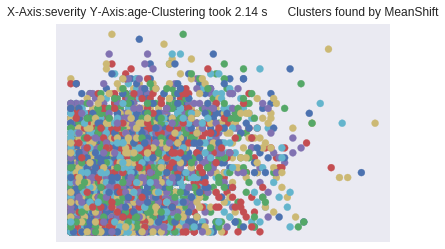

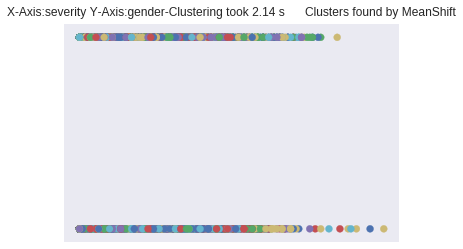

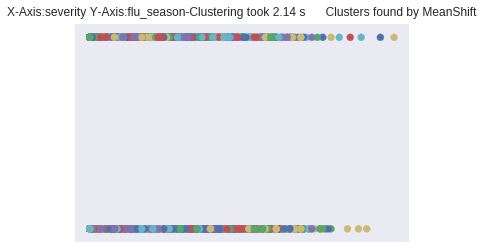

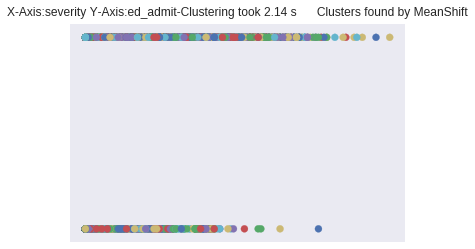

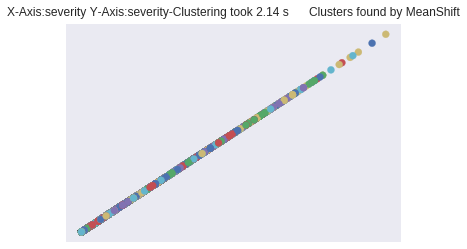

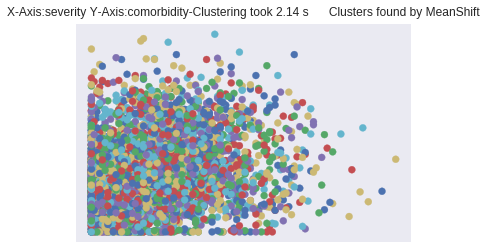

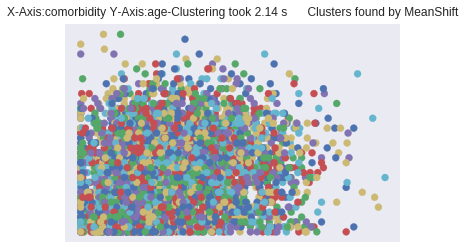

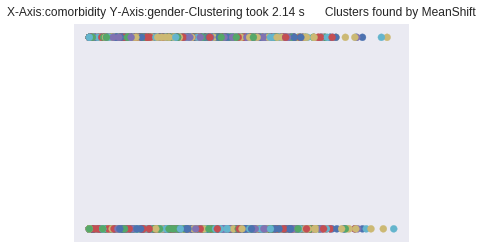

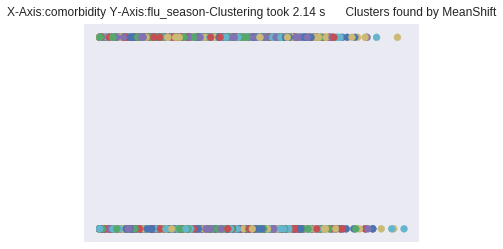

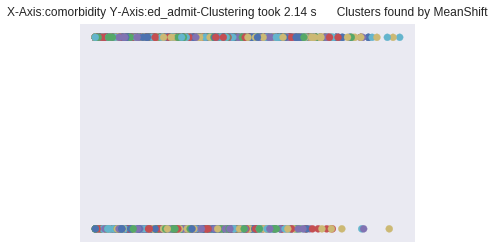

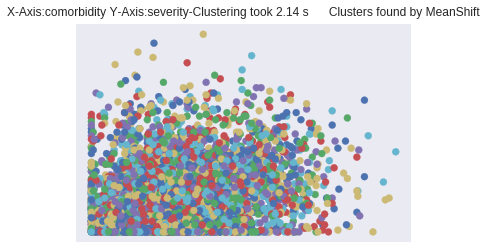

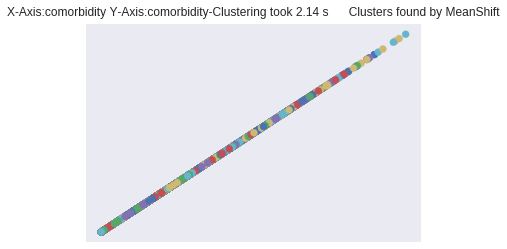

In [51]:
plot_clusters(X, MeanShift, (0.175,), {'cluster_all':True})

###### AgglomerativeClustering.

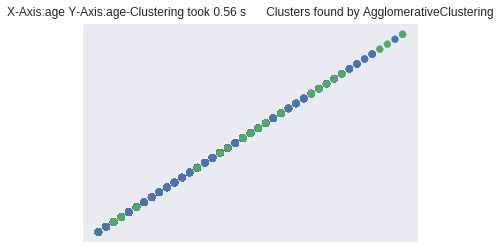

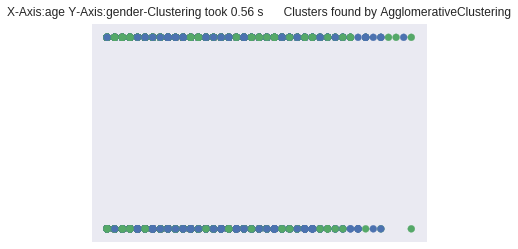

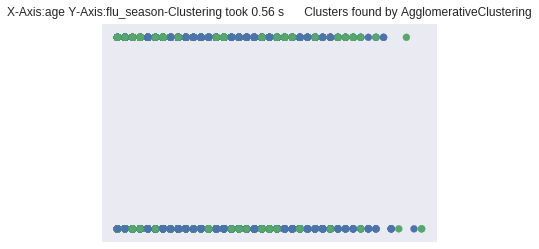

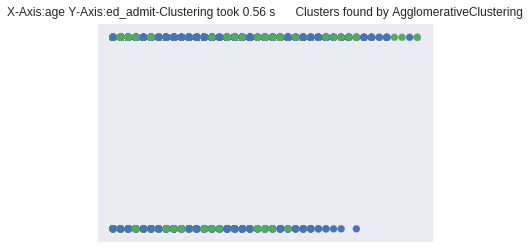

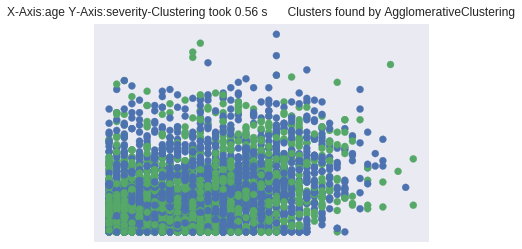

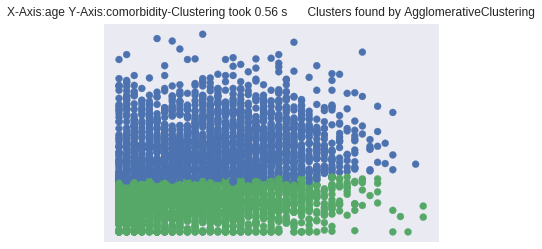

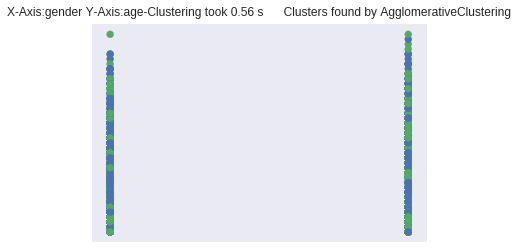

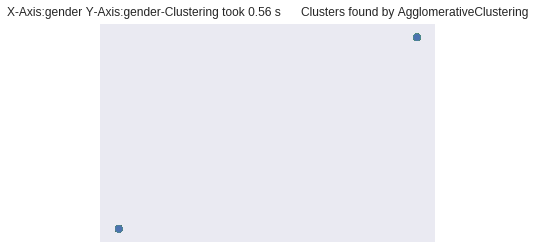

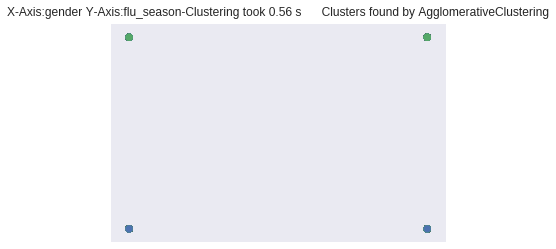

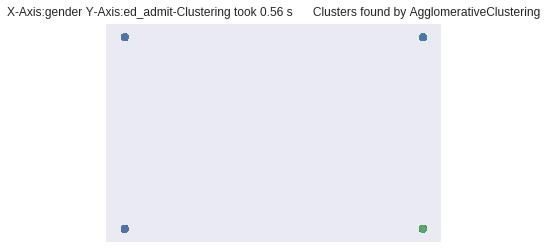

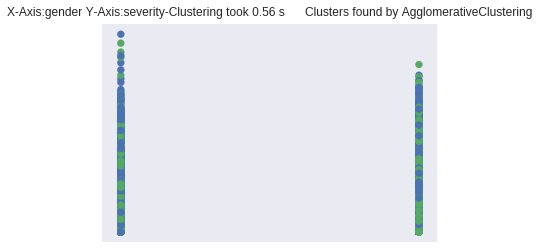

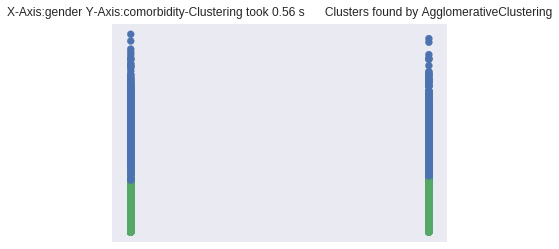

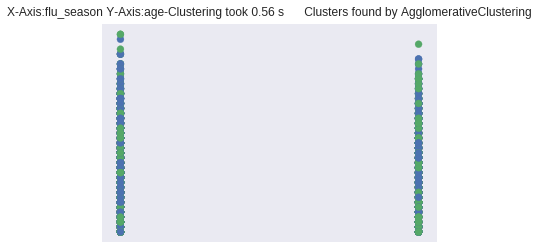

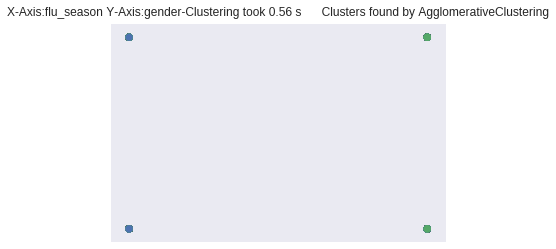

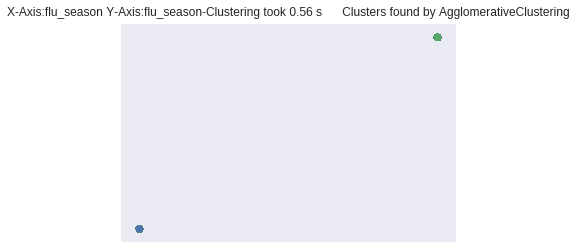

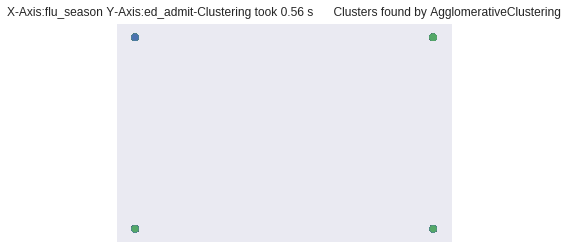

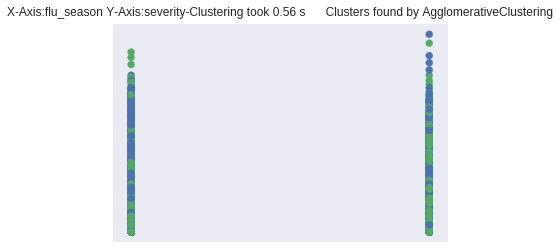

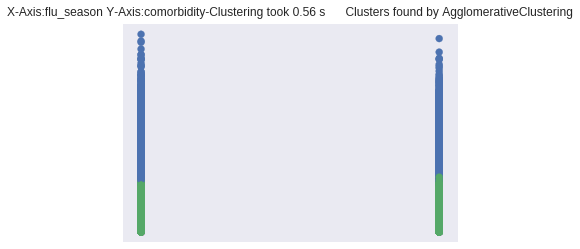

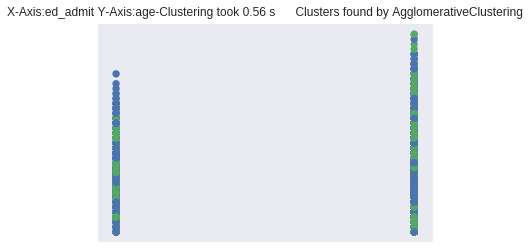

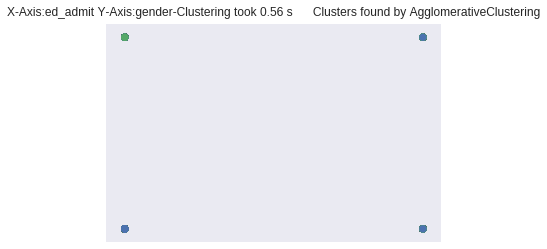

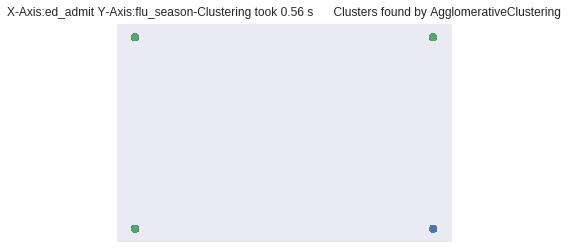

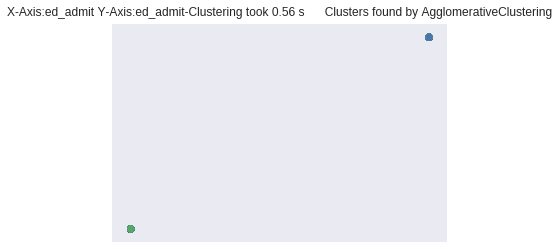

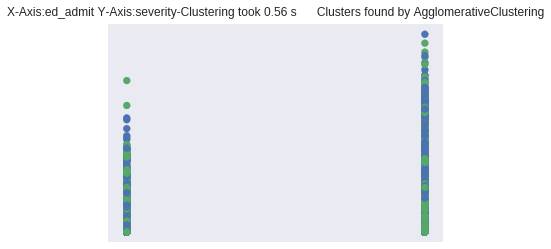

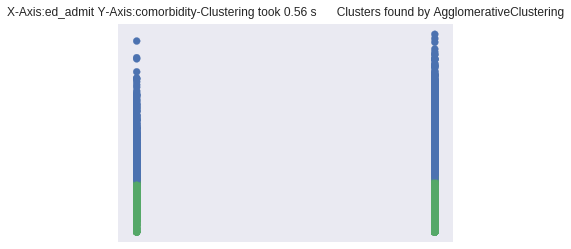

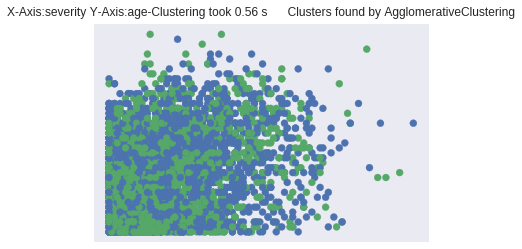

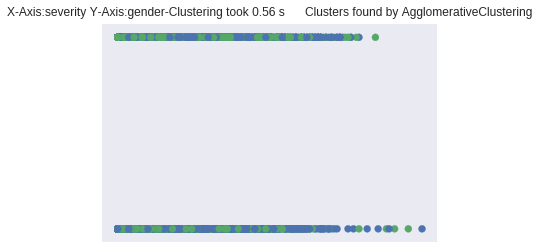

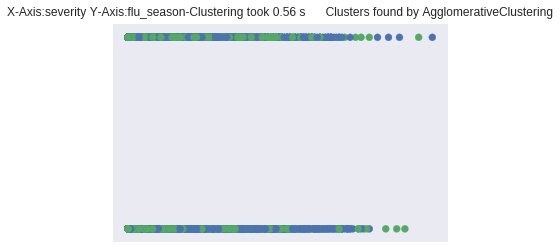

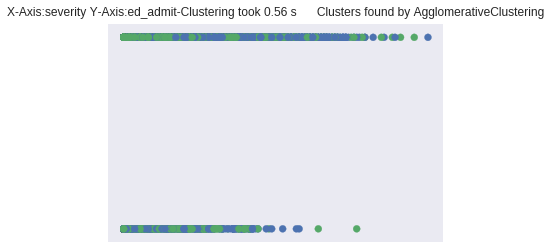

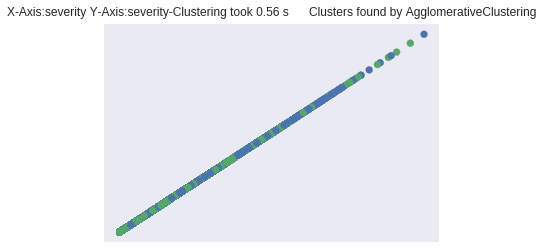

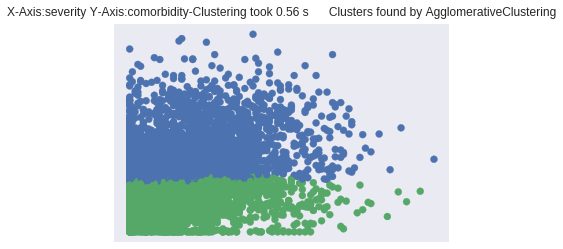

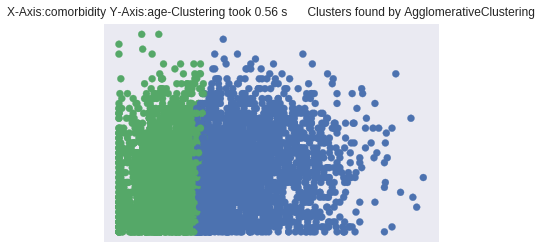

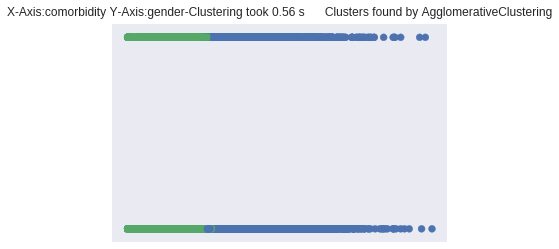

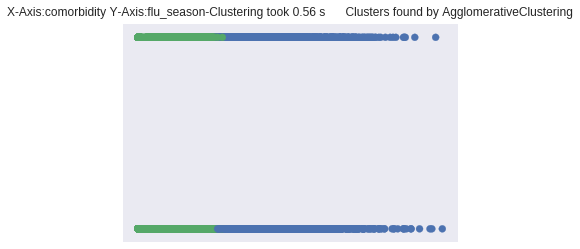

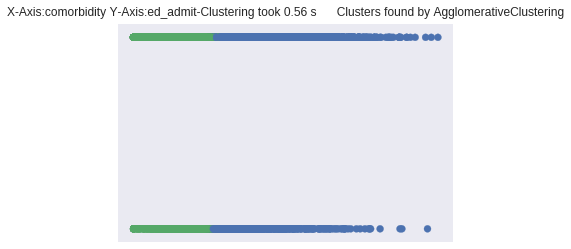

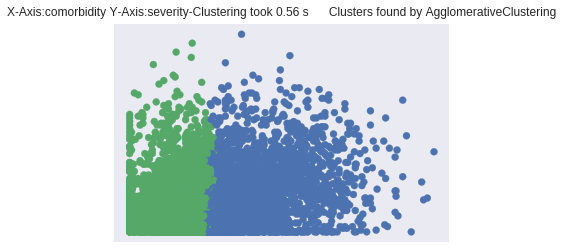

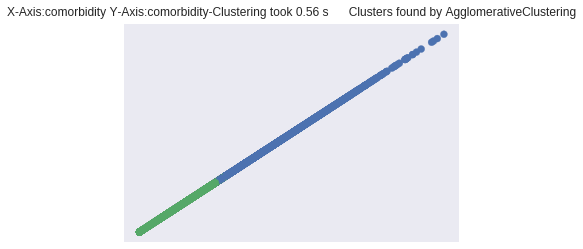

In [52]:
plot_clusters(X, AgglomerativeClustering, (), {'n_clusters':2, 'linkage':'ward'})

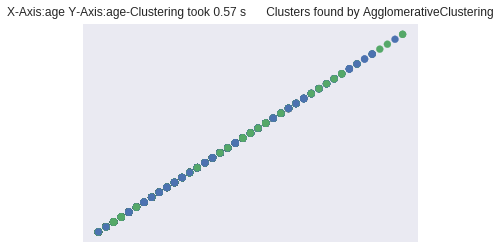

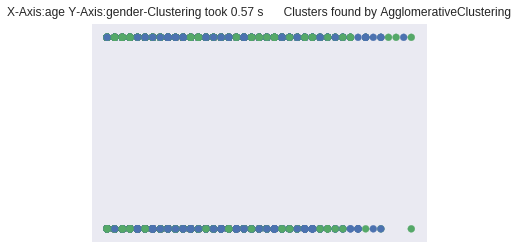

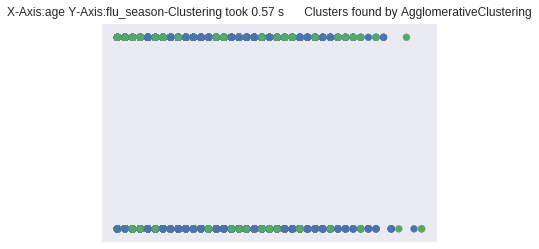

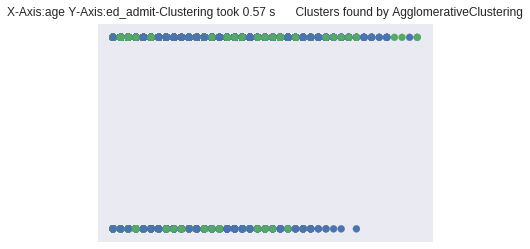

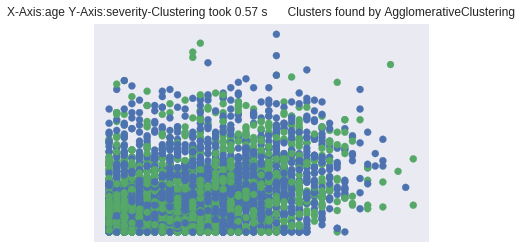

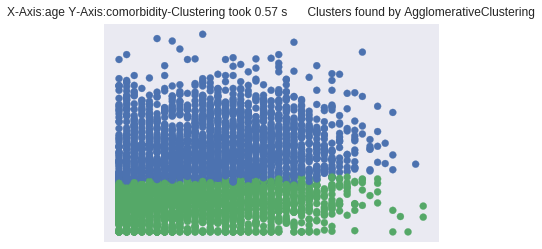

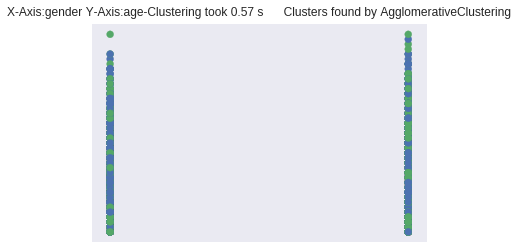

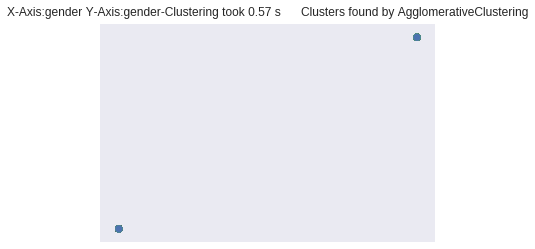

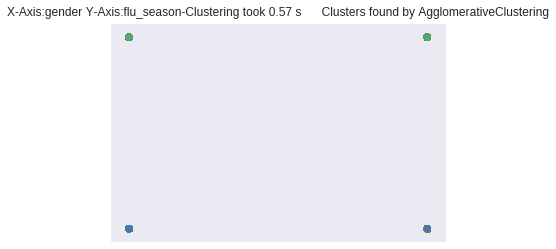

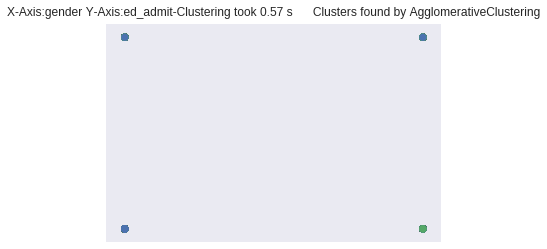

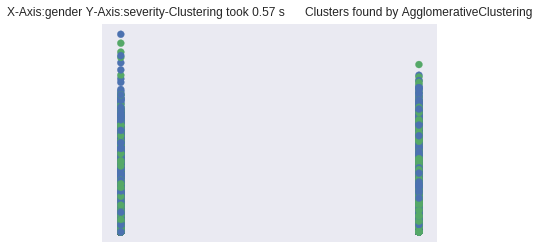

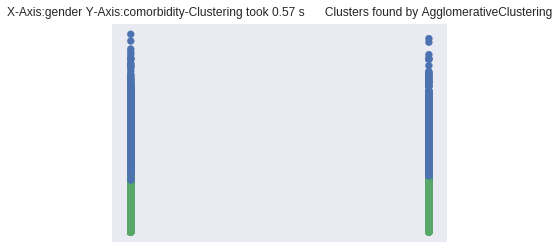

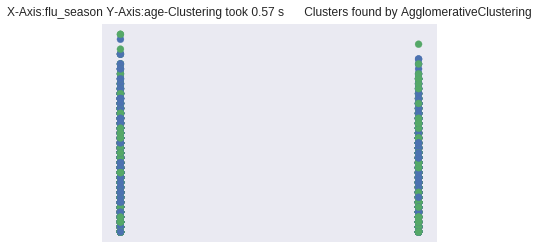

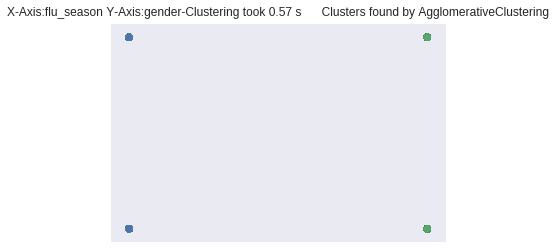

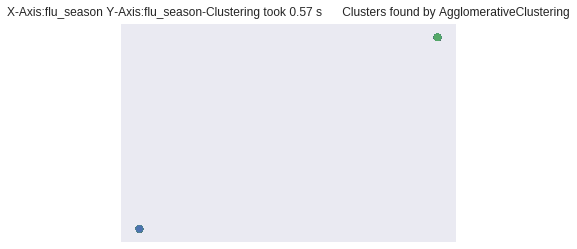

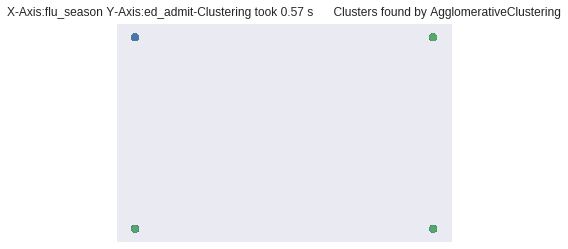

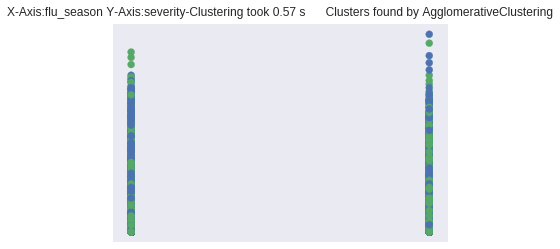

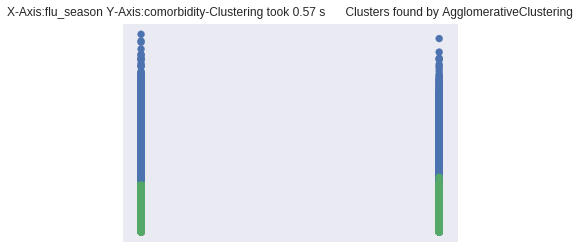

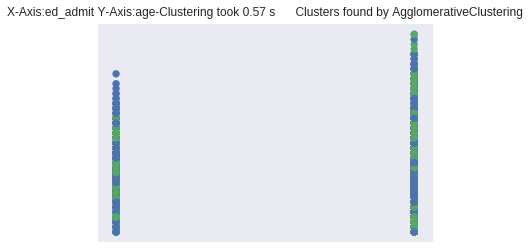

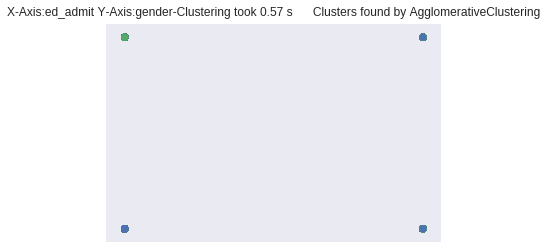

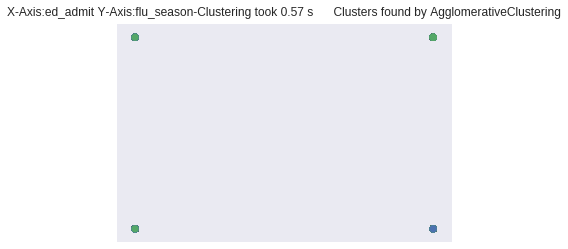

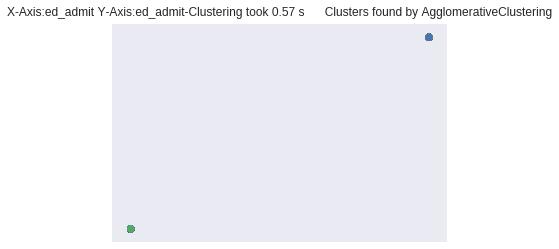

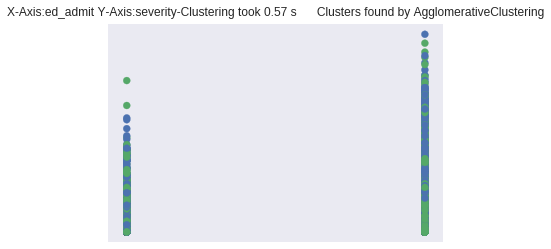

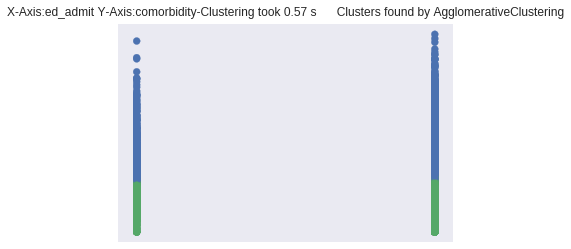

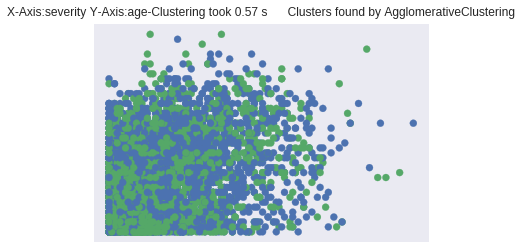

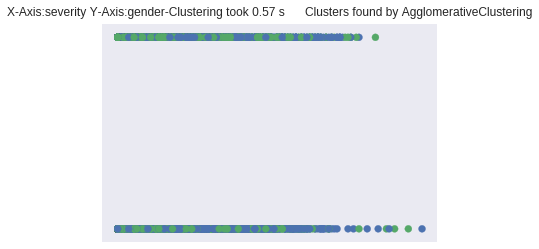

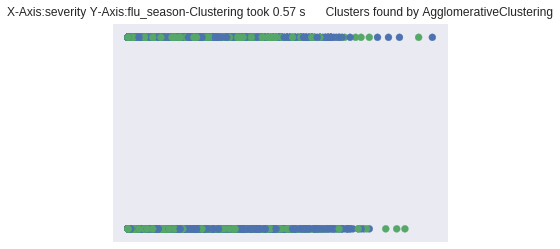

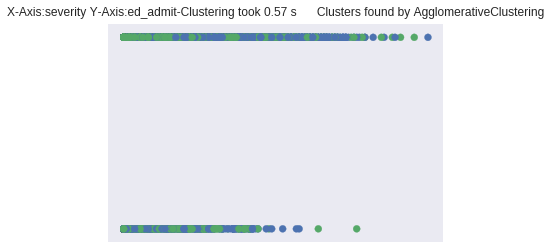

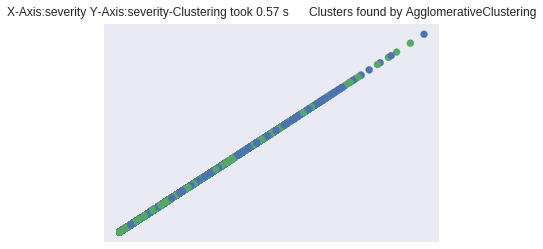

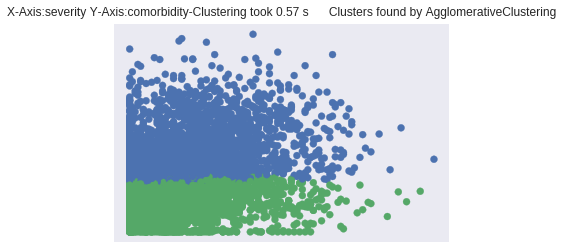

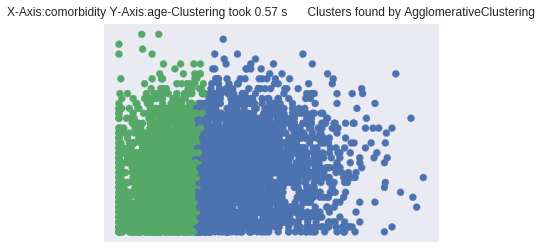

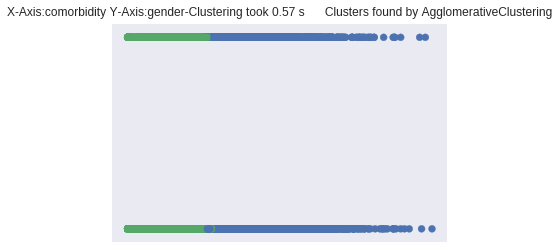

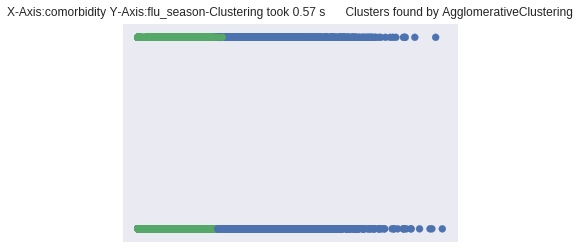

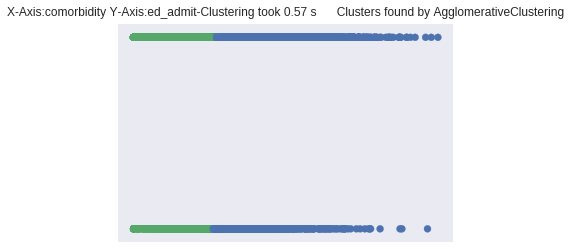

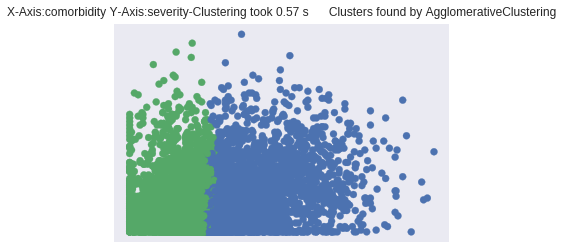

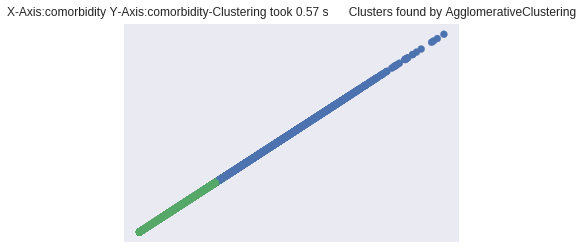

In [53]:
plot_clusters(X, AgglomerativeClustering, (), {'linkage':'ward'})

###### DBSCAN.

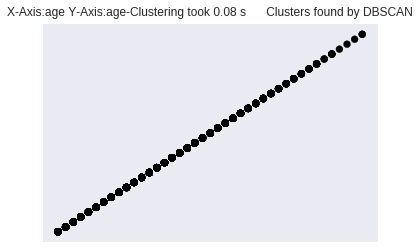

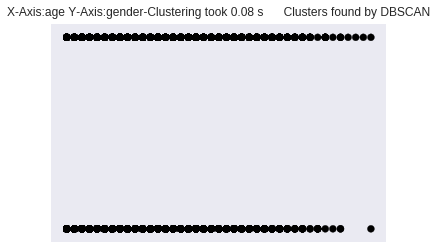

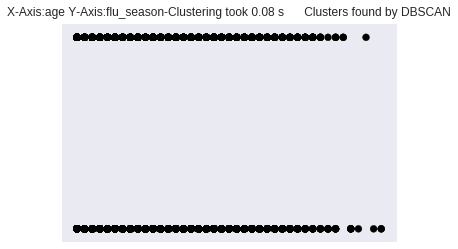

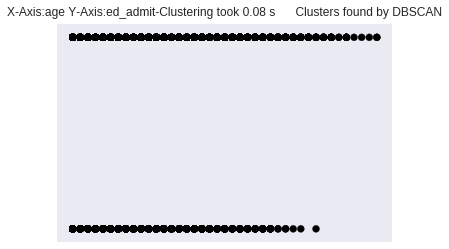

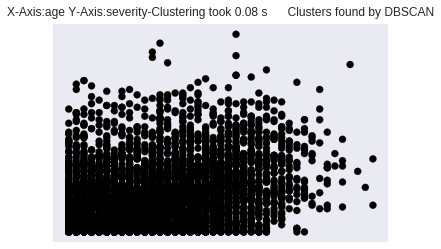

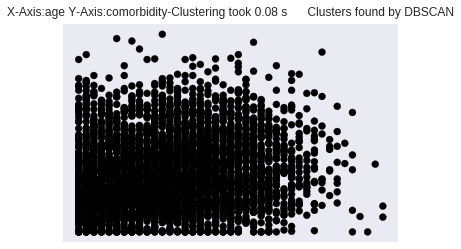

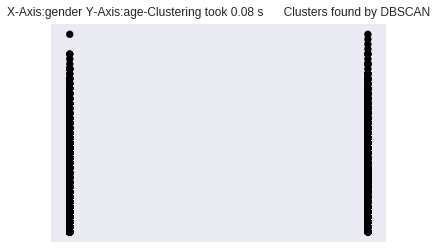

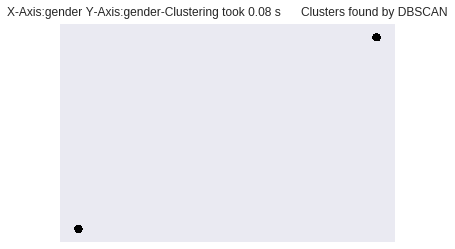

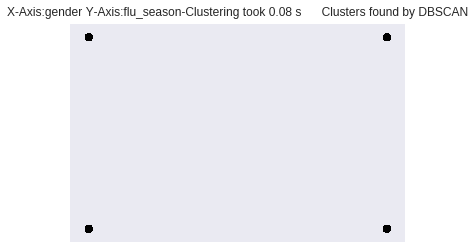

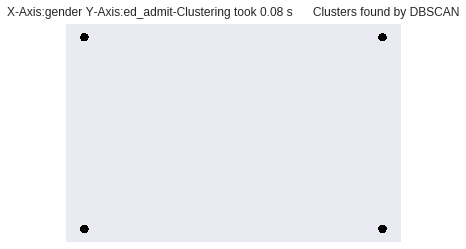

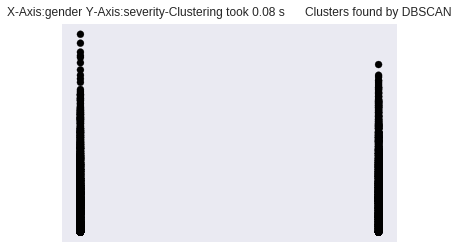

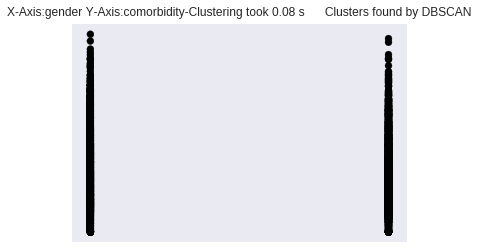

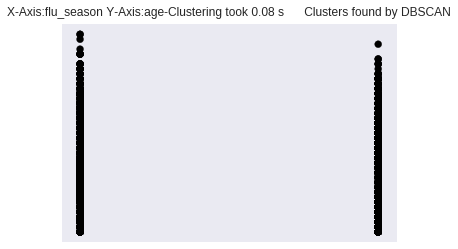

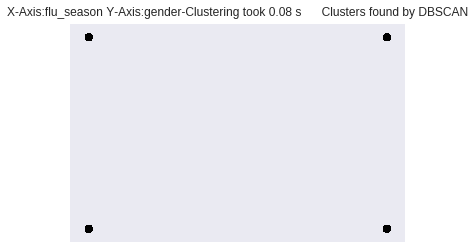

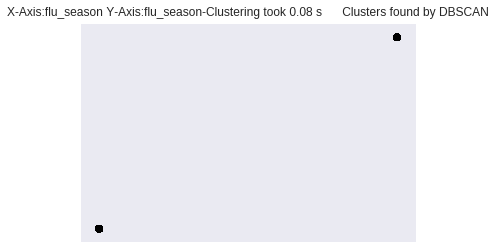

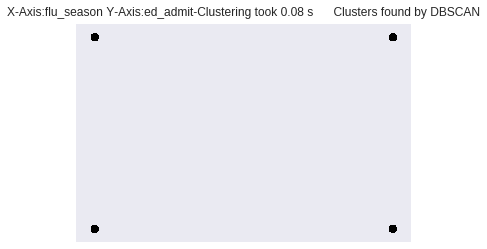

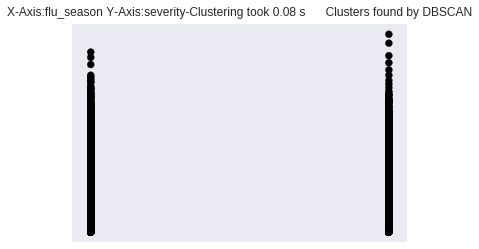

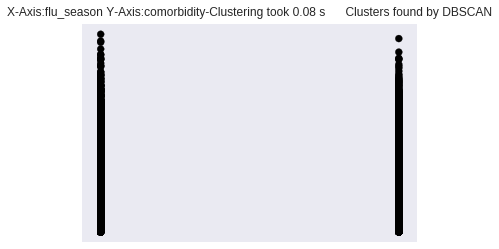

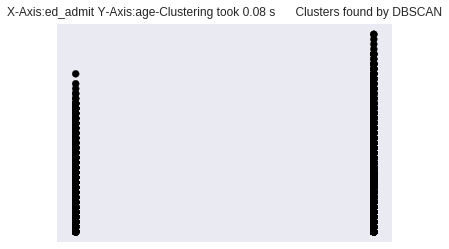

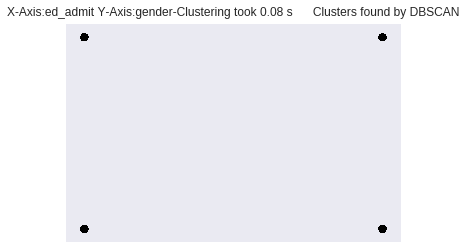

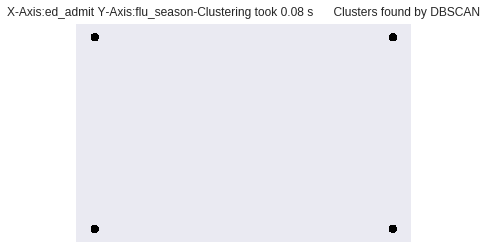

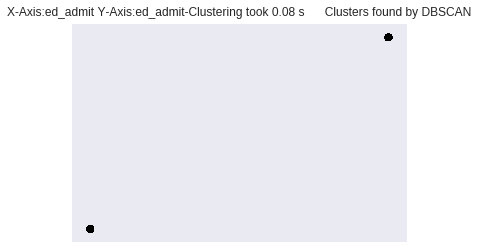

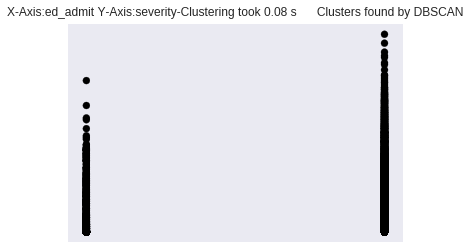

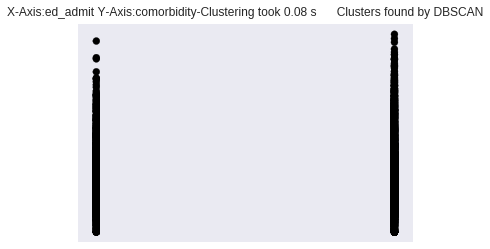

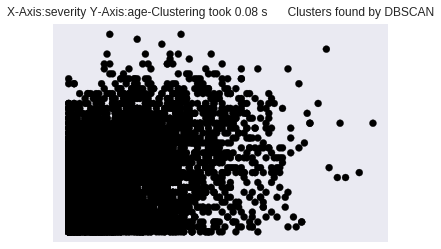

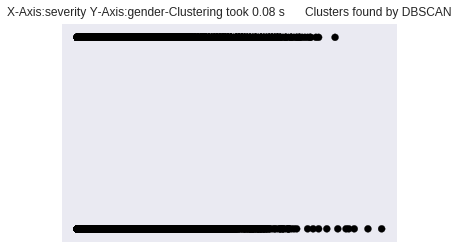

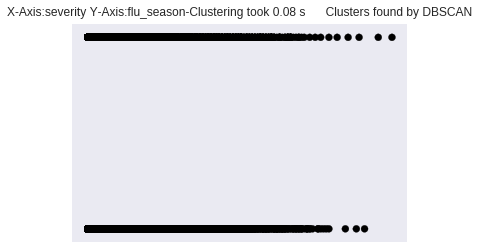

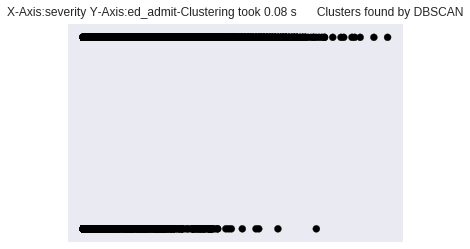

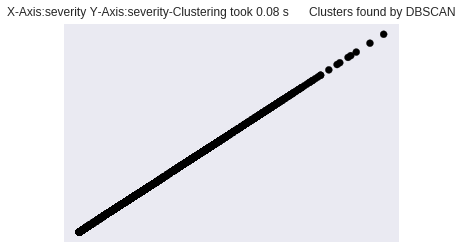

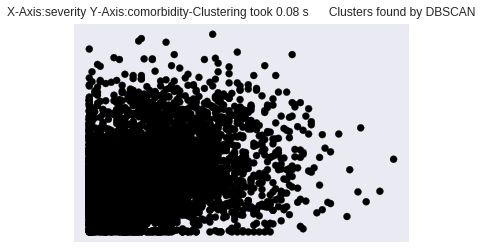

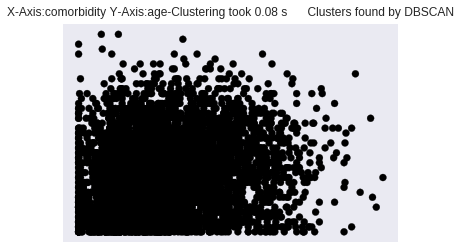

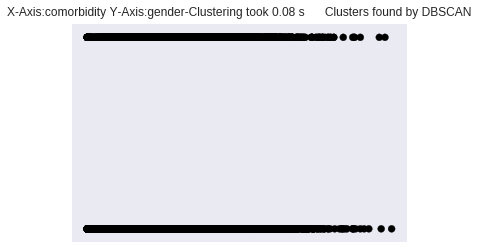

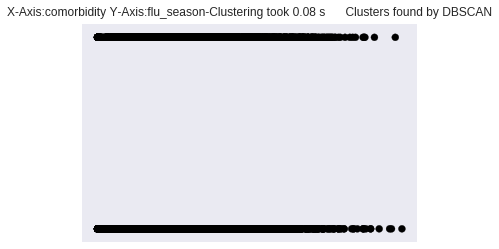

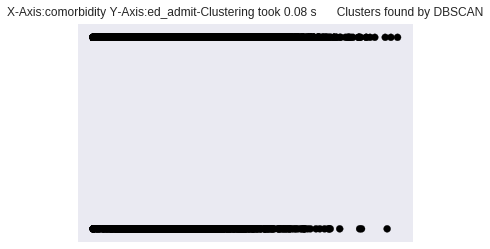

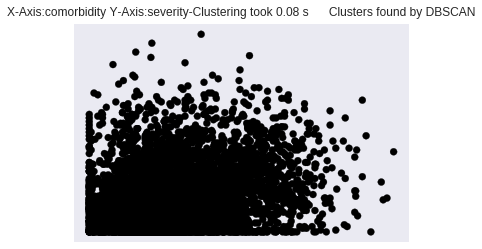

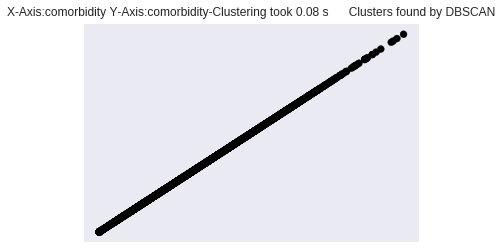

In [54]:
plot_clusters(X, DBSCAN, (), {'eps':0.025})

###### All algorithms find 2 clusters for comorbidity and age as the optimal clustering strategy.

#### Assign clusters to the dataset.

In [55]:
clustermodel = AgglomerativeClustering()
clustermodel.fit((list(frame.age),list(frame.comorbidity)))
agg = clustermodel.labels_

#### Normalize dataset for clustering.

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

/home/ubuntu/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [57]:
frame.head()

age  gender  flu_season  ed_admit  severity  comorbidity  readmit30  \
0  100       1           1         1        38          112          0   
1   83       1           0         1         8          109          1   
2   74       0           1         0         1           80          0   
3   66       1           1         1        25            4          0   
4   68       1           1         1        25           32          0   

   cluster_feature  
0               -1  
1                1  
2                1  
3                1  
4                1

#### Plotting the clusters and silhouette scores.

For n_clusters = 2 The average silhouette_score is : 0.259322967923


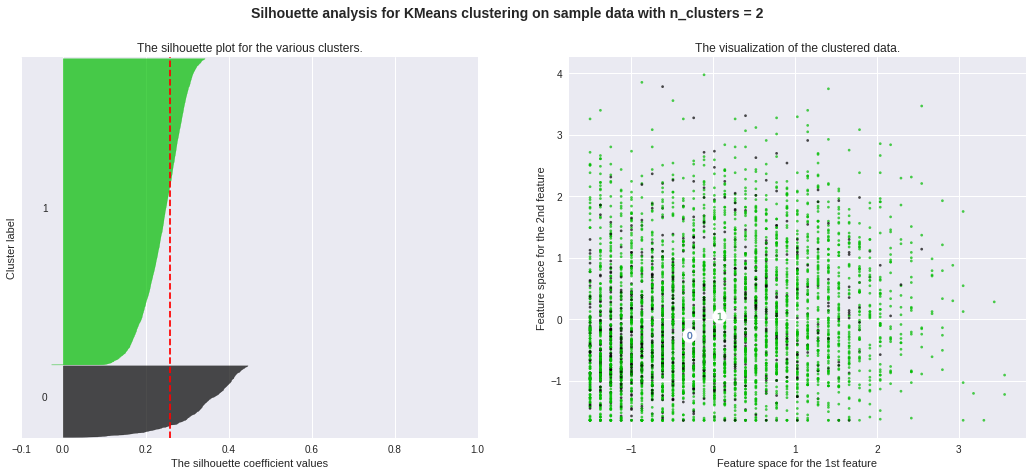

For n_clusters = 3 The average silhouette_score is : 0.234219324726


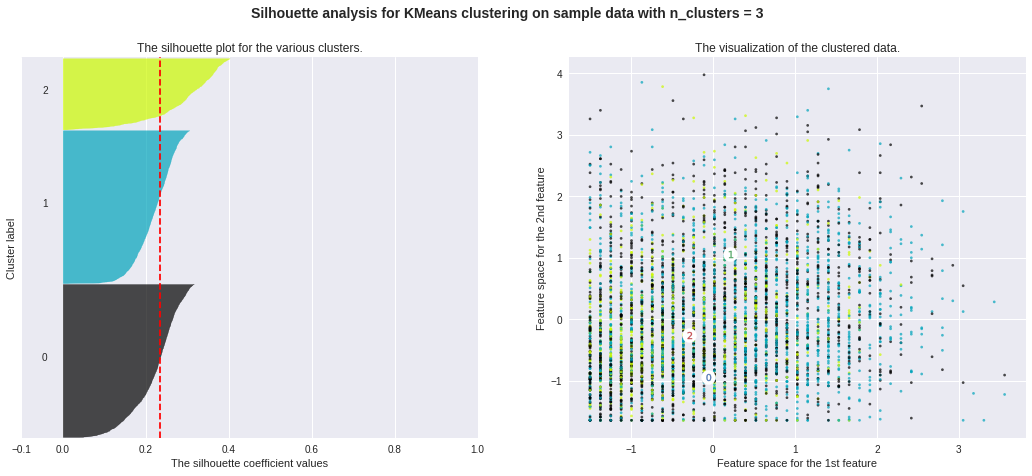

For n_clusters = 4 The average silhouette_score is : 0.215397012895


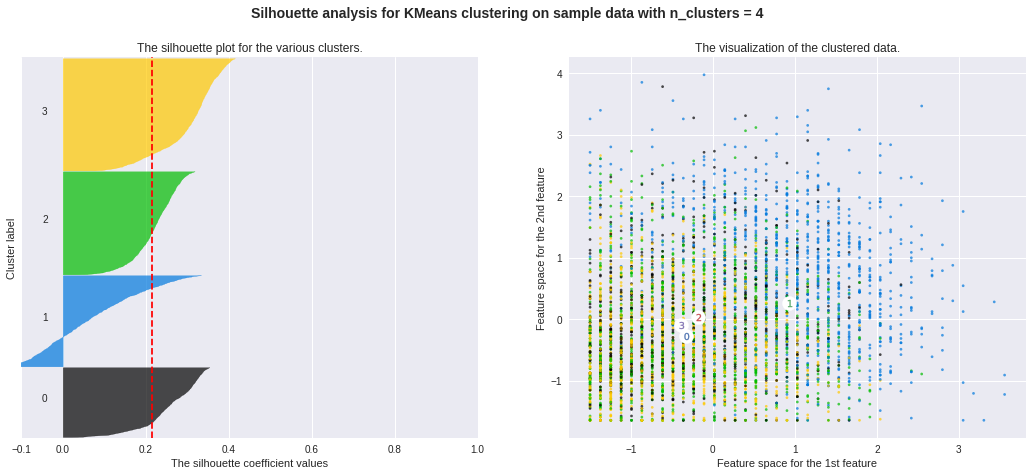

For n_clusters = 5 The average silhouette_score is : 0.224811651689


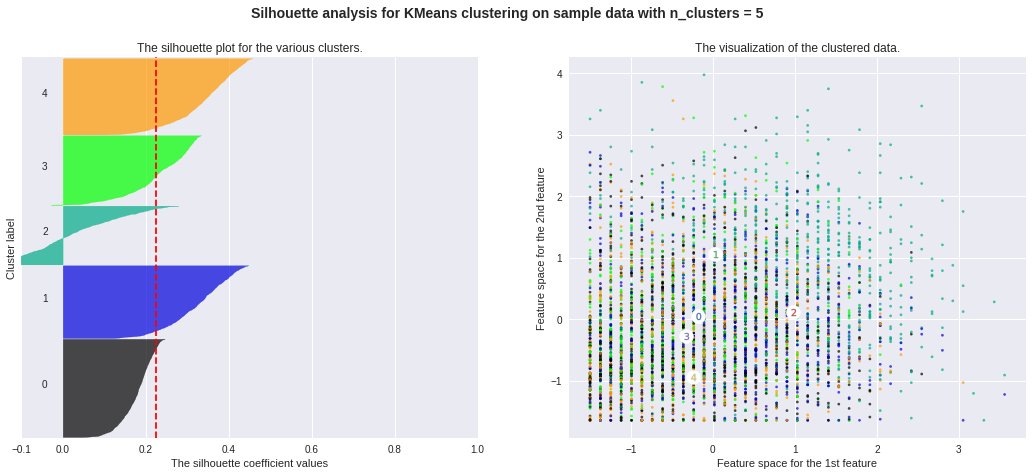

For n_clusters = 6 The average silhouette_score is : 0.254407591887


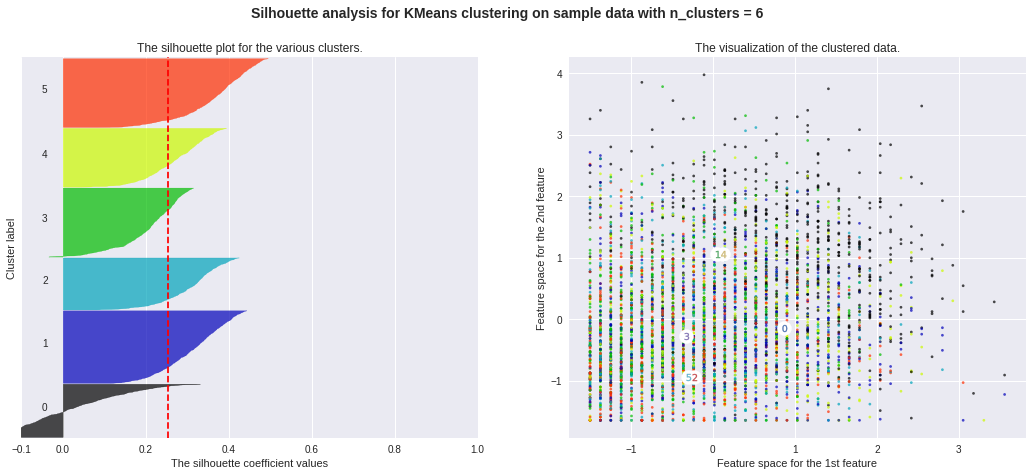

For n_clusters = 7 The average silhouette_score is : 0.252820397125


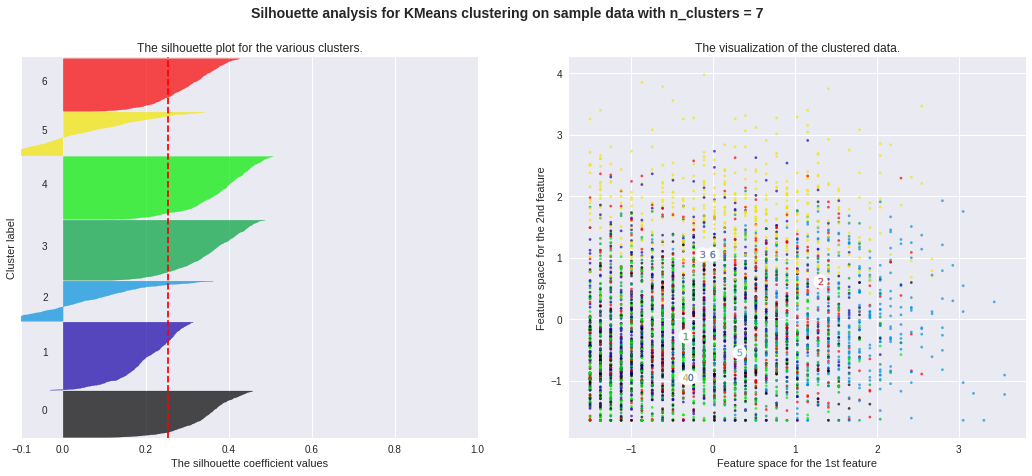

For n_clusters = 8 The average silhouette_score is : 0.269449664003


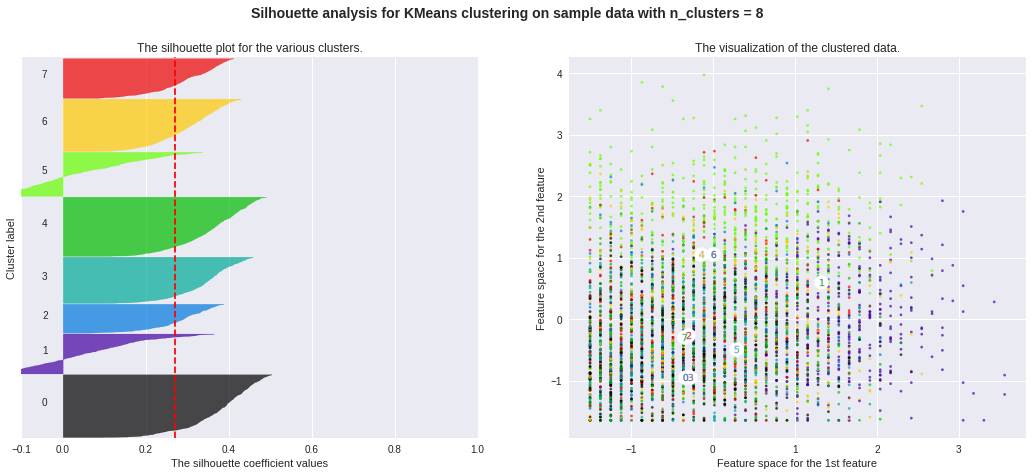

For n_clusters = 9 The average silhouette_score is : 0.270617468997


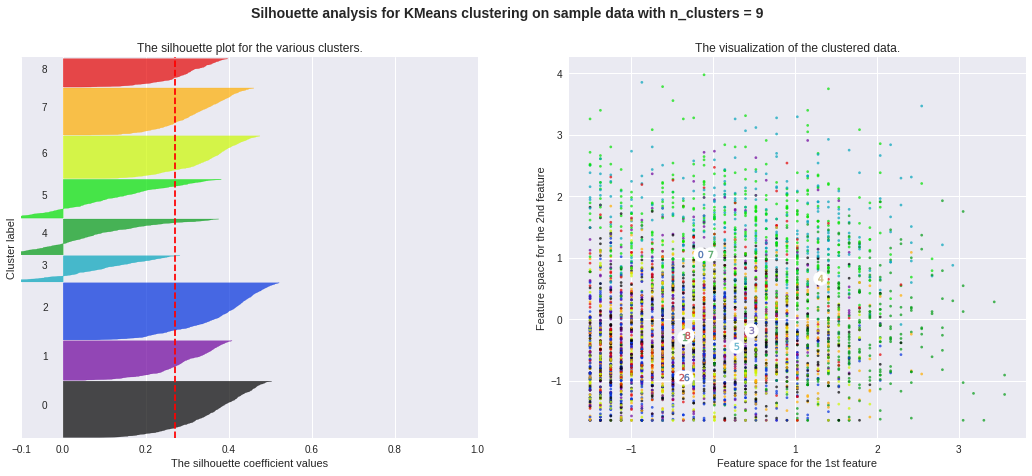

For n_clusters = 10 The average silhouette_score is : 0.267155146718


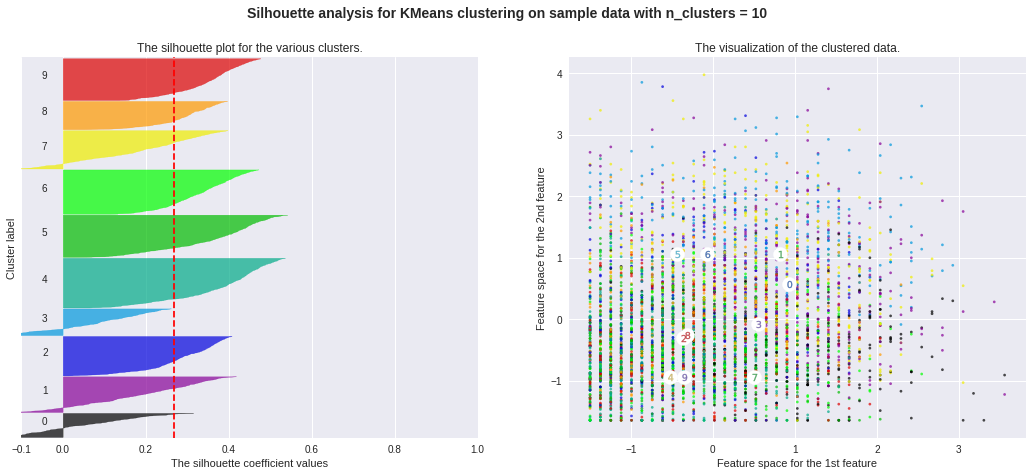

In [58]:
#http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_range = range( 2, 11 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict( X_scaled )

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(X_scaled, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  # Age and comorbidity
  ax2.scatter(X_scaled[:, 0], X_scaled[:, 5], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()

#### Fit and predict cluster numbers from best number of clusters and features.

In [59]:
clusterer = KMeans(n_clusters=2, random_state=42)
cluster_labels = clusterer.fit_predict( X_scaled )   
X_scaled.shape, cluster_labels.shape

((4372, 6), (4372,))

In [60]:
np.unique(cluster_labels), sum(np.isnan(cluster_labels)), np.sum(cluster_labels), cluster_labels.shape[0] - np.sum(cluster_labels)

(array([0, 1], dtype=int32), 0, 3543, 829)

#### Add cluster number feature to X.

In [61]:
frame['cluster_feature'] = cluster_labels

In [62]:
frame.head()

age  gender  flu_season  ed_admit  severity  comorbidity  readmit30  \
0  100       1           1         1        38          112          0   
1   83       1           0         1         8          109          1   
2   74       0           1         0         1           80          0   
3   66       1           1         1        25            4          0   
4   68       1           1         1        25           32          0   

   cluster_feature  
0                1  
1                1  
2                0  
3                1  
4                1

#### Split to train and test.

In [63]:
cluster_X = np.array(frame[['age']+['comorbidity']].values.tolist())
cluster_Y = frame['readmit30'].values.tolist()
cluster_X_train, cluster_X_test, cluster_y_train, cluster_y_test = train_test_split(cluster_X,cluster_Y)

## Logistic Regression on Cluster and related Features.

#### Fit Logistic Regression for class imbalanced data.

In [64]:
log.fit(cluster_X_train, cluster_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Predict.

In [65]:
preds = log.predict(cluster_X_test)
predsprob = log.predict_proba(cluster_X_test)

#### Gather our Metrics.

In [66]:
# Model, Accuracy, R2, RMSE, F1
metrics.append(['Log Regression-Cluster',
                float(str(round(abs(accuracy_score(cluster_y_test, preds)),4))),
                float(str(round(abs(r2_score(cluster_y_test, preds)),4))),
                float(str(round(abs(euclidean(cluster_y_test, preds)/math.sqrt(len(cluster_y_test))),4))),
                float(str(round(abs(f1_score(cluster_y_test, preds)),4)))])
metrics

[['Log Regression-Class imbalanced', 0.8106, 0.0922, 0.4352, 0.4136],
 ['Log Regression-Class balance(undersample)', 0.7273, 2.3737, 0.5222, 0.3099],
 ['Random Forest-Class imbalanced', 0.796, 0.1766, 0.4517, 0.2875],
 ['Random Forest-Class balance(undersample)', 0.7165, 2.5071, 0.5324, 0.2956],
 ['Log Regression-Cluster', 0.796, 0.1942, 0.4517, 0.3138]]

#### Compare Model metrics.

In [67]:
pd.DataFrame(metrics, columns = ['ml_model', 'accuracy', 'r2', 'rmse', 'f1_score'])

ml_model  accuracy      r2    rmse  \
0            Log Regression-Class imbalanced    0.8106  0.0922  0.4352   
1  Log Regression-Class balance(undersample)    0.7273  2.3737  0.5222   
2             Random Forest-Class imbalanced    0.7960  0.1766  0.4517   
3   Random Forest-Class balance(undersample)    0.7165  2.5071  0.5324   
4                     Log Regression-Cluster    0.7960  0.1942  0.4517   

   f1_score  
0    0.4136  
1    0.3099  
2    0.2875  
3    0.2956  
4    0.3138

#### Plot ROCs for Models.

In [68]:
log.fit(X_train, y_train)
log_fpr,log_tpr,log_threshold = roc_curve(y_test, [_[1] for _ in log.predict_proba(X_test)])
log_roc_auc = auc(log_fpr, log_tpr)

log.fit(new_X_train, new_y_train)
bal_log_fpr,bal_log_tpr,bal_log_threshold = roc_curve(new_y_test, [_[1] for _ in log.predict_proba(new_X_test)])
bal_log_roc_auc = auc(bal_log_fpr, bal_log_tpr)

rf.fit(X_train, y_train)
rf_fpr,rf_tpr,rf_threshold = roc_curve(y_test, [_[1] for _ in rf.predict_proba(X_test)])
rf_roc_auc = auc(rf_fpr, rf_tpr)

rf.fit(new_X_train, new_y_train)
bal_rf_fpr,bal_rf_tpr,bal_rf_threshold = roc_curve(new_y_test, [_[1] for _ in rf.predict_proba(new_X_test)])
bal_rf_roc_auc = auc(bal_rf_fpr, bal_rf_tpr)

log.fit(cluster_X_train, cluster_y_train)
cluster_log_fpr,cluster_log_tpr,cluster_log_threshold = roc_curve(cluster_y_test, [_[1] for _ in log.predict_proba(cluster_X_test)])
cluster_log_roc_auc = auc(cluster_log_fpr, cluster_log_tpr)


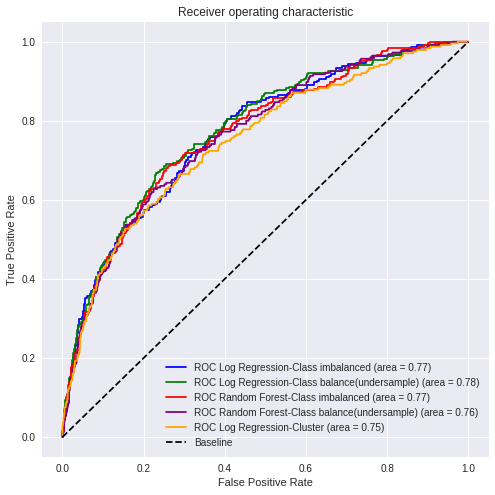

In [69]:
plt.figure(figsize=(8,8))
plt.plot(log_fpr, log_tpr, color='blue', label='ROC Log Regression-Class imbalanced (area = %0.2f)' % (log_roc_auc))
plt.plot(bal_log_fpr, bal_log_tpr, color='green', label='ROC Log Regression-Class balance(undersample) (area = %0.2f)' % (bal_log_roc_auc))
plt.plot(rf_fpr, rf_tpr, color='red', label='ROC Random Forest-Class imbalanced (area = %0.2f)' % (rf_roc_auc))
plt.plot(bal_rf_fpr, bal_rf_tpr, color='purple', label='ROC Random Forest-Class balance(undersample) (area = %0.2f)' % (bal_rf_roc_auc))
plt.plot(cluster_log_fpr, cluster_log_tpr, color='orange', label='ROC Log Regression-Cluster (area = %0.2f)' % (cluster_log_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label = "Baseline")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4)

#### Visualizing Confusion Matrix  Function.

In [70]:
#http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
def show_confusion_matrix(C,class_labels=['0','1'], plot_color='Black', model=''):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(10,6))
    plt.title('Confusion Matrix', fontdict={'fontsize':16}, loc= 'right')
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.get_cmap(plot_color+'s'))

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], plot_color, lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], plot_color, lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], plot_color, lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], plot_color, lw=2)

    # Set xlabels
    ax.set_xlabel(model+'-Predicted Label', fontsize=14)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=14, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    
    plt.tight_layout()
    plt.show()

#### Confusion matrix for models.

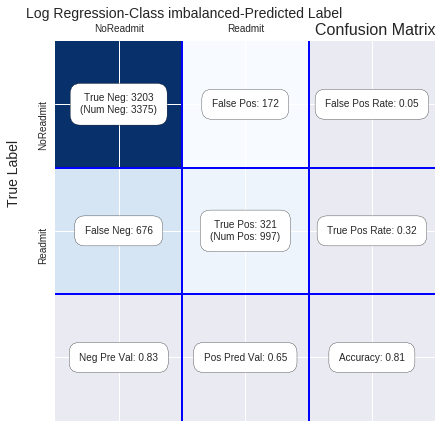

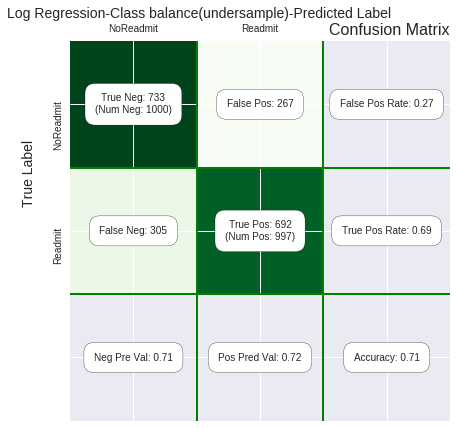

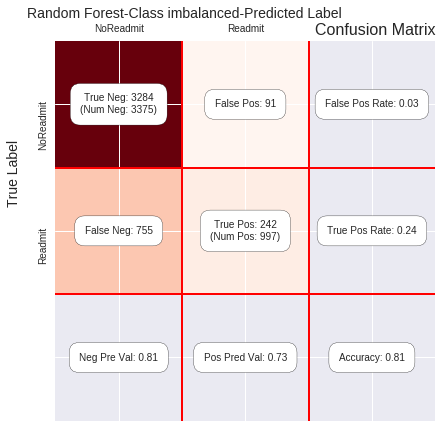

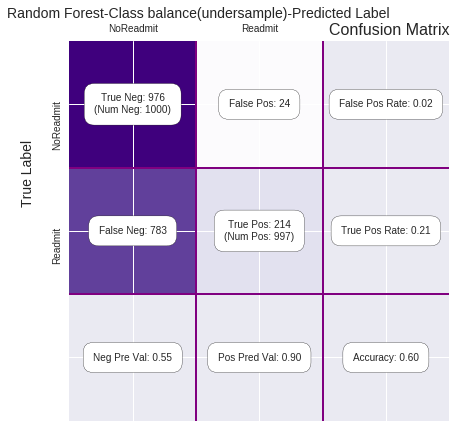

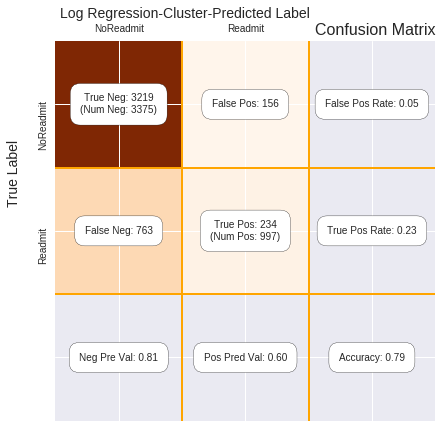

In [71]:
log.fit(X_train, y_train)
log_cm = confusion_matrix(Y, log.predict(X))

log.fit(new_X_train, new_y_train)
bal_log_cm = confusion_matrix(new_Y, log.predict(new_X))

rf.fit(X_train, y_train)
rf_cm = confusion_matrix(Y, rf.predict(X))

rf.fit(X_train, y_train)
bal_rf_cm = confusion_matrix(new_Y, rf.predict(new_X))

log.fit(cluster_X_train, cluster_y_train)
cluster_log_cm = confusion_matrix(cluster_Y, log.predict(cluster_X))

show_confusion_matrix(log_cm,['NoReadmit','Readmit'], 'Blue', 'Log Regression-Class imbalanced')
print("\n\n")
show_confusion_matrix(bal_log_cm,['NoReadmit','Readmit'], 'Green', 'Log Regression-Class balance(undersample)')
print("\n\n")
show_confusion_matrix(rf_cm,['NoReadmit','Readmit'], 'Red', 'Random Forest-Class imbalanced')
print("\n\n")
show_confusion_matrix(bal_rf_cm,['NoReadmit','Readmit'], 'Purple', 'Random Forest-Class balance(undersample)')
print("\n\n")
show_confusion_matrix(cluster_log_cm,['NoReadmit','Readmit'], 'Orange', 'Log Regression-Cluster')

In [72]:
num_noreadmit = 3384
num_readmit = 998
fine_readmit = 8000
cost_care = 1200

In [73]:
#Negative : NoReadmit
#Positive : Readmit
tp_cost = cost_care + fine_readmit # Care provision and Readmit Fine
tn_cost = 0 # No readmit fine and no care provision
fp_cost = cost_care # Care provision cost but no readmit fine
fn_cost = fine_readmit # Readmit fine but no care provision

log_tp_num = log_cm[1][1]
log_tn_num = log_cm[0][0]
log_fp_num = log_cm[0][1]
log_fn_num = log_cm[1][0]

bal_log_tp_num = bal_log_cm[1][1]
bal_log_tn_num = bal_log_cm[0][0]
bal_log_fp_num = bal_log_cm[0][1]
bal_log_fn_num = bal_log_cm[1][0]

rf_tp_num = rf_cm[1][1]
rf_tn_num = rf_cm[0][0]
rf_fp_num = rf_cm[0][1]
rf_fn_num = rf_cm[1][0]

bal_rf_tp_num = bal_rf_cm[1][1]
bal_rf_tn_num = bal_rf_cm[0][0]
bal_rf_fp_num = bal_rf_cm[0][1]
bal_rf_fn_num = bal_rf_cm[1][0]

cluster_log_tp_num = cluster_log_cm[1][1]
cluster_log_tn_num = cluster_log_cm[0][0]
cluster_log_fp_num = cluster_log_cm[0][1]
cluster_log_fn_num = cluster_log_cm[1][0]


In [74]:
tot_no_care = num_readmit * fine_readmit
tot_all_care = (num_noreadmit+num_readmit)*cost_care + 0.6*(num_readmit)*fine_readmit
tot_log_care = (log_tp_num*tp_cost)+(log_tn_num*tn_cost)+(log_fp_num*fp_cost)+(log_fn_num*fn_cost)
tot_bal_log_care = (bal_log_tp_num*tp_cost)+(bal_log_tn_num*tn_cost)+(bal_log_fp_num*fp_cost)+(bal_log_fn_num*fn_cost)
tot_rf_care = (rf_tp_num*tp_cost)+(rf_tn_num*tn_cost)+(rf_fp_num*fp_cost)+(rf_fn_num*fn_cost)
tot_bal_rf_care = (bal_rf_tp_num*tp_cost)+(bal_rf_tn_num*tn_cost)+(bal_rf_fp_num*fp_cost)+(bal_rf_fn_num*fn_cost)
tot_cluster_log_care = (cluster_log_tp_num*tp_cost)+(cluster_log_tn_num*tn_cost)+(cluster_log_fp_num*fp_cost)+(cluster_log_fn_num*fn_cost)


In [75]:
pd.DataFrame([["None", tot_no_care], 
              ["All", tot_all_care], 
              ["Predict Log Regression-Class imbalanced",tot_log_care],
              ["Predict Log Regression-Class balance(undersample)",tot_bal_log_care],
              ["Predict Random Forest-Class imbalanced",tot_rf_care],
              ["Predict Random Forest-Class balance(undersample)",tot_bal_rf_care],
              ["Predict Log Regression-Cluster",tot_cluster_log_care]
             ],
             columns = ["Model based Care", "Cost - $"])

Model based Care    Cost - $
0                                               None   7984000.0
1                                                All  10048800.0
2            Predict Log Regression-Class imbalanced   8567600.0
3  Predict Log Regression-Class balance(undersample)   9126800.0
4             Predict Random Forest-Class imbalanced   8375600.0
5   Predict Random Forest-Class balance(undersample)   8261600.0
6                     Predict Log Regression-Cluster   8444000.0